In [3]:
gauged_reaches=c(4, 544, 568, 562, 658, 571, 653, 662, 668, 665, 575, 584, 674, 593, 677, 681, 678, 687, 796, 689, 619, 694, 702, 613, 613, 613, 698, 635, 627, 704, 639, 639, 719, 710, 643, 737, 739, 554, 750, 759, 764, 775, 802, 803, 520, 877, 836, 916, 539, 1331, 305, 307, 341, 345, 347, 887, 890, 891, 893, 903, 901, 896, 905, 957, 965, 952, 937, 947, 946, 941, 944, 939, 1150, 1139, 1141, 1126, 1154, 1174, 1203, 1202, 1198, 1197, 1208, 1310, 1228, 1220, 1298, 1214, 1262, 1274, 1288, 1268, 1278, 1303, 1290, 1282, 1336, 1307, 1325, 51, 47, 30, 36, 40, 43, 421, 54, 166, 59, 63, 424, 435, 456, 482, 328, 338, 335, 1077, 997, 998, 1117, 1001, 1013, 1016, 1029, 1041, 1044, 1245, 1052, 1255, 1246)

In [63]:
# setwd('/nas/cee-water/cjgleason/colin/neobam/')

#  for (i in 1:length(gauged_reaches)){
#   # i=22

# index=gauged_reaches[i]
# source('run_neobam.R')

#   outname=paste0('/nas/cee-water/cjgleason/colin/neobam/tempoutput/output',as.character(i),'.rds')
# saveRDS(neobam_output,file=outname)
      
#  }





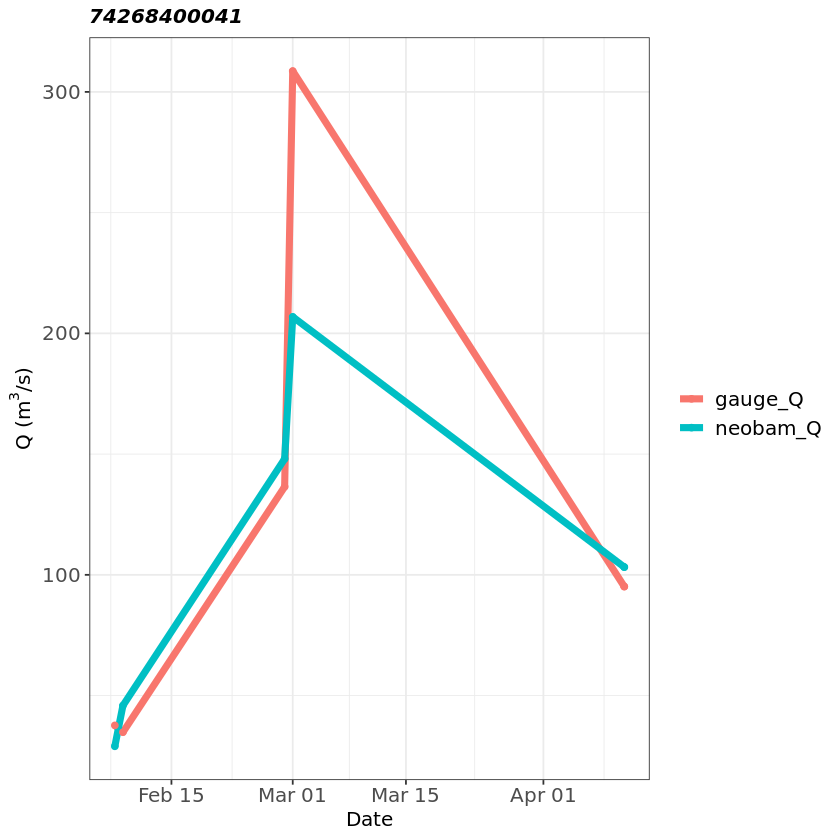

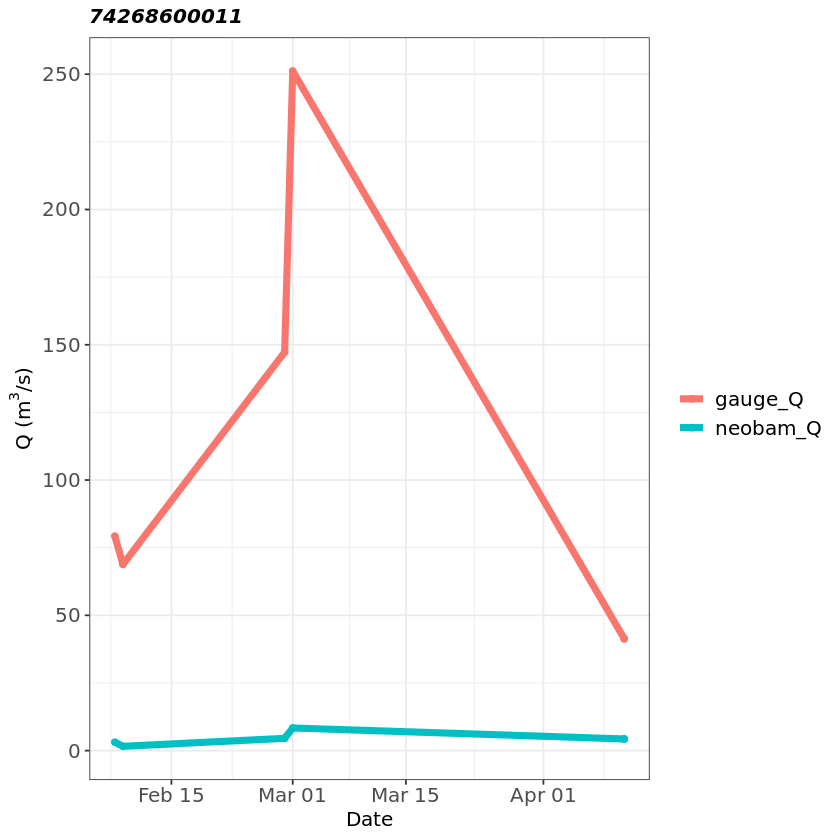

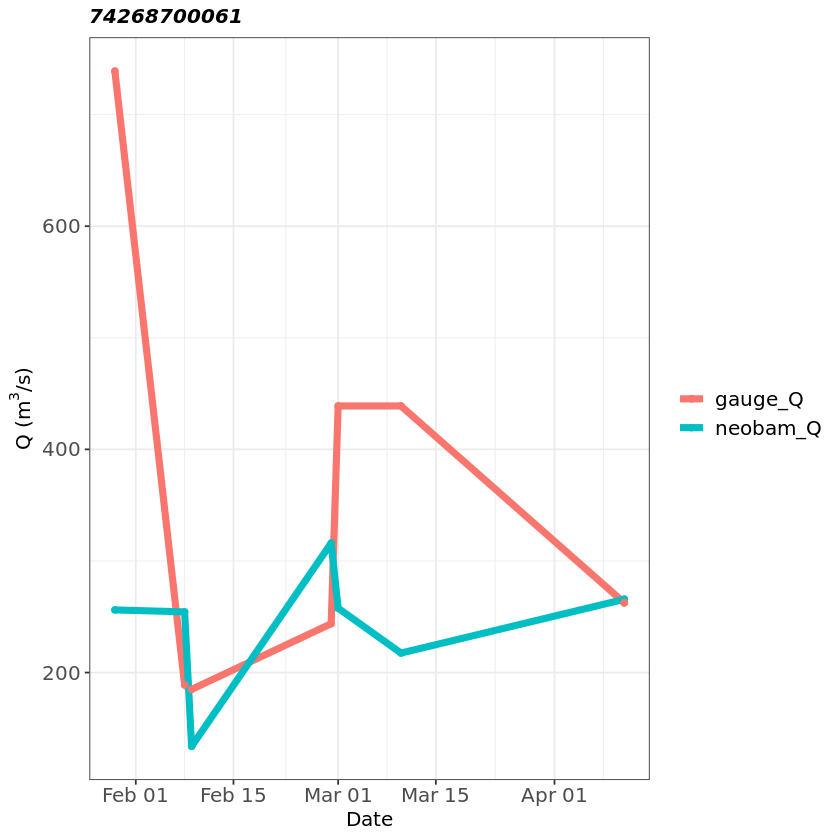

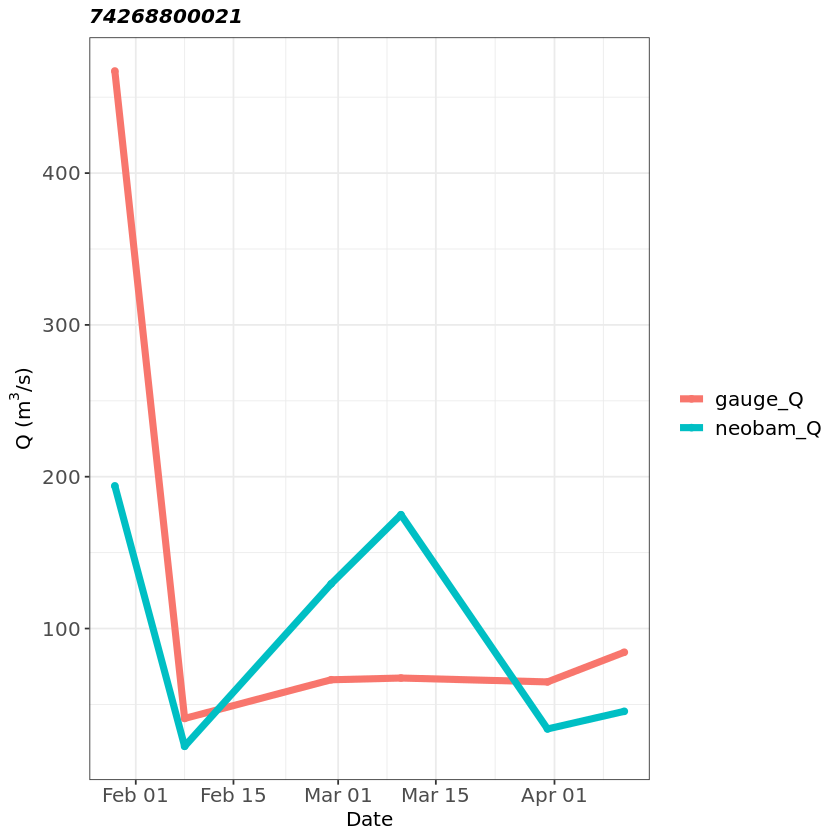

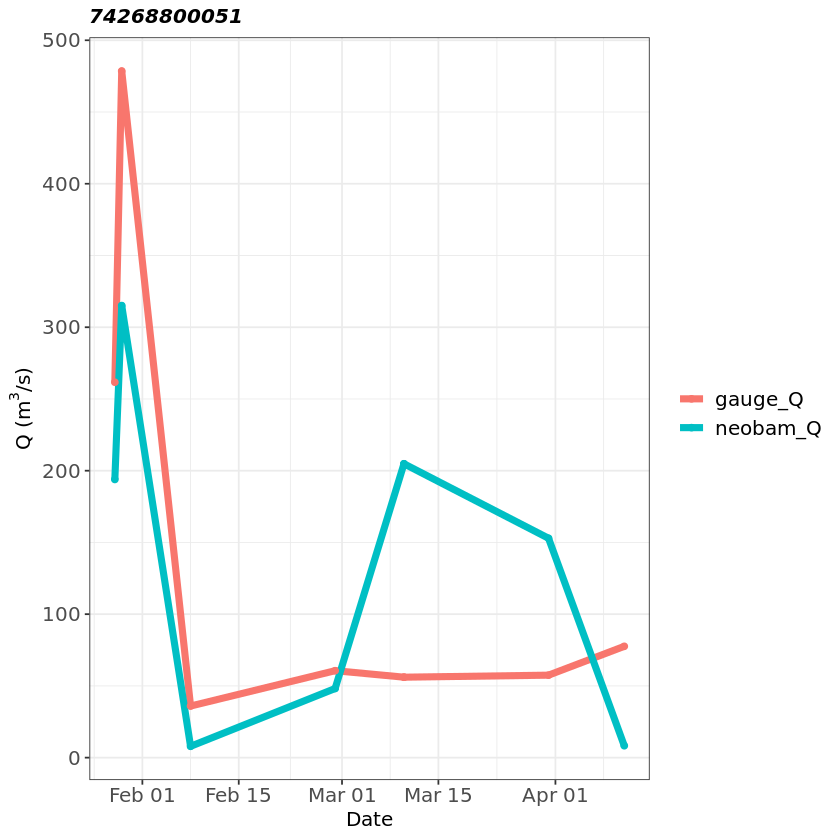

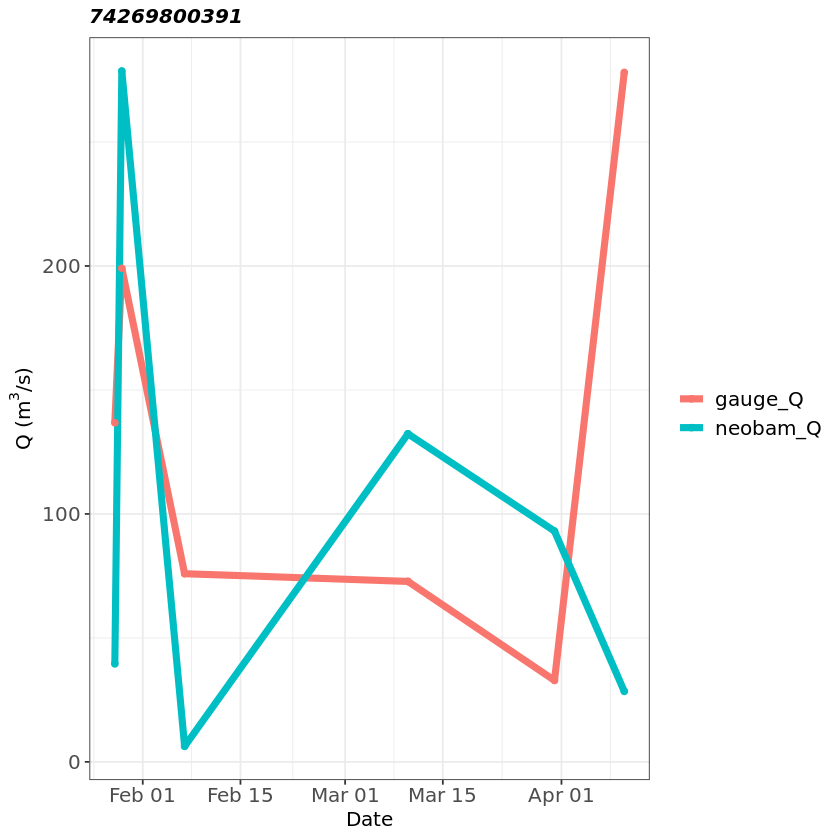

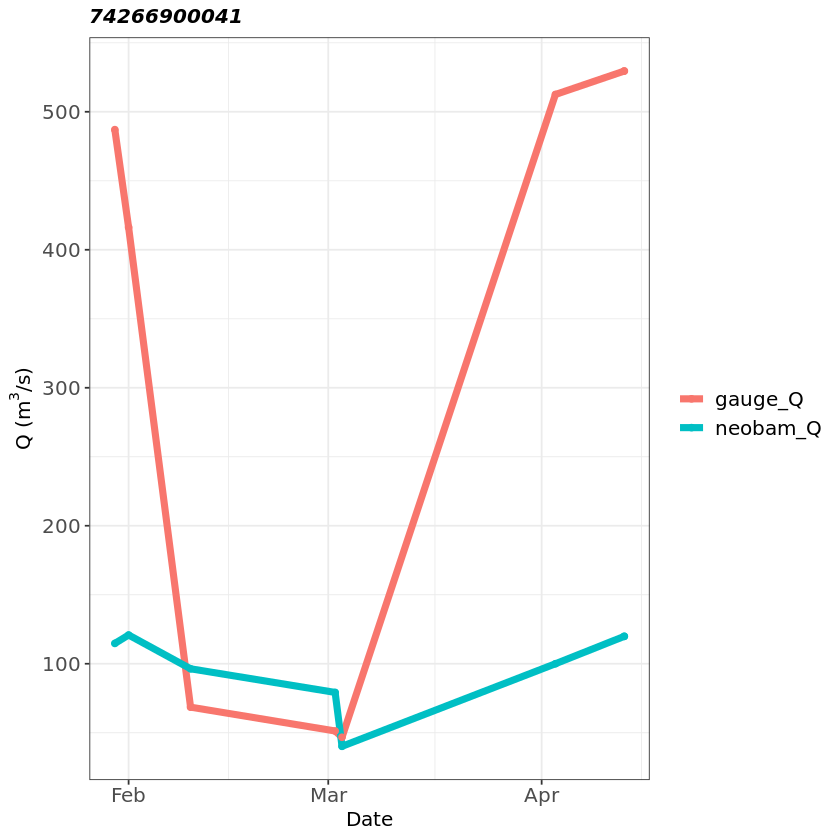

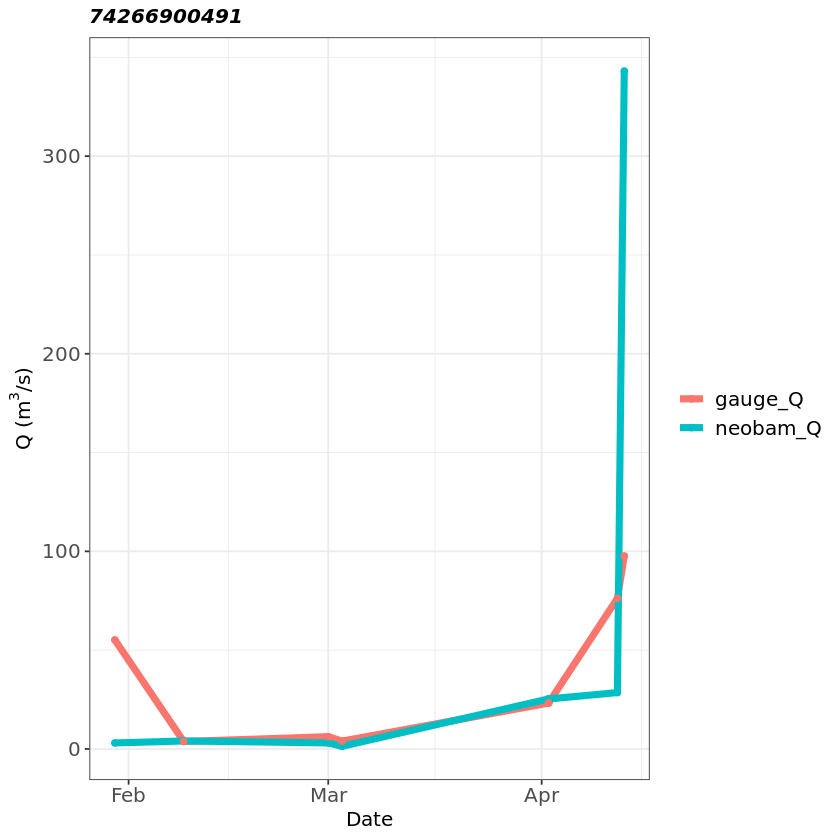

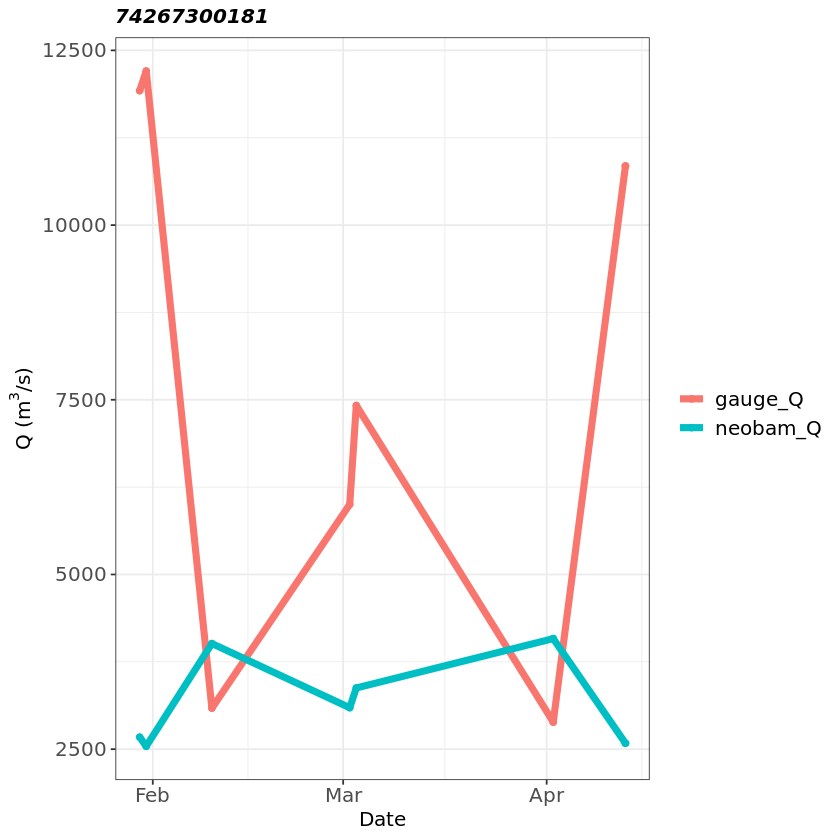

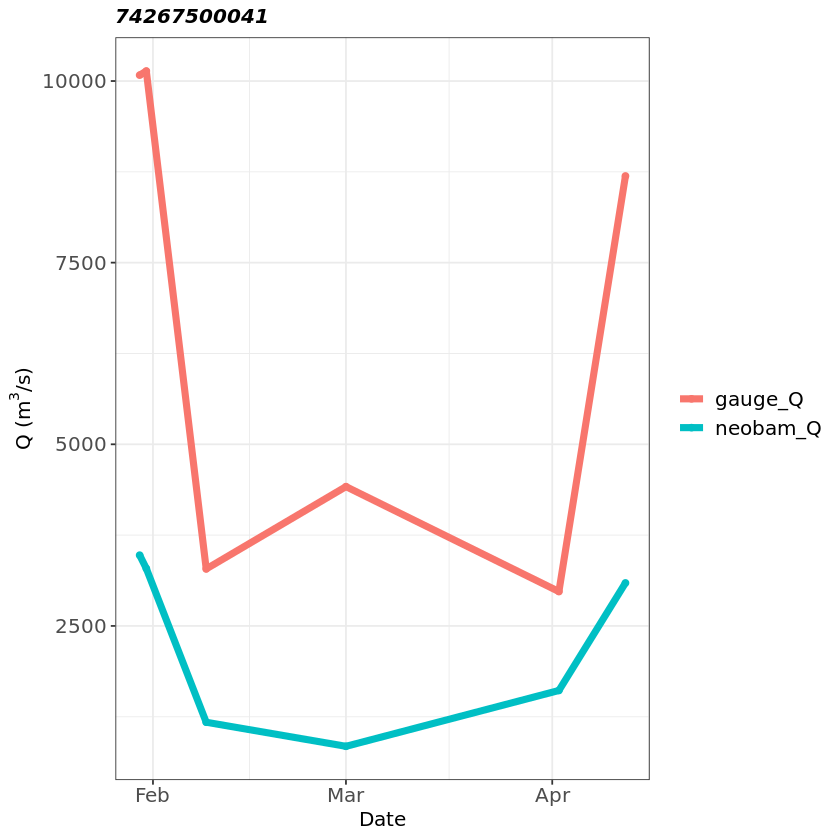

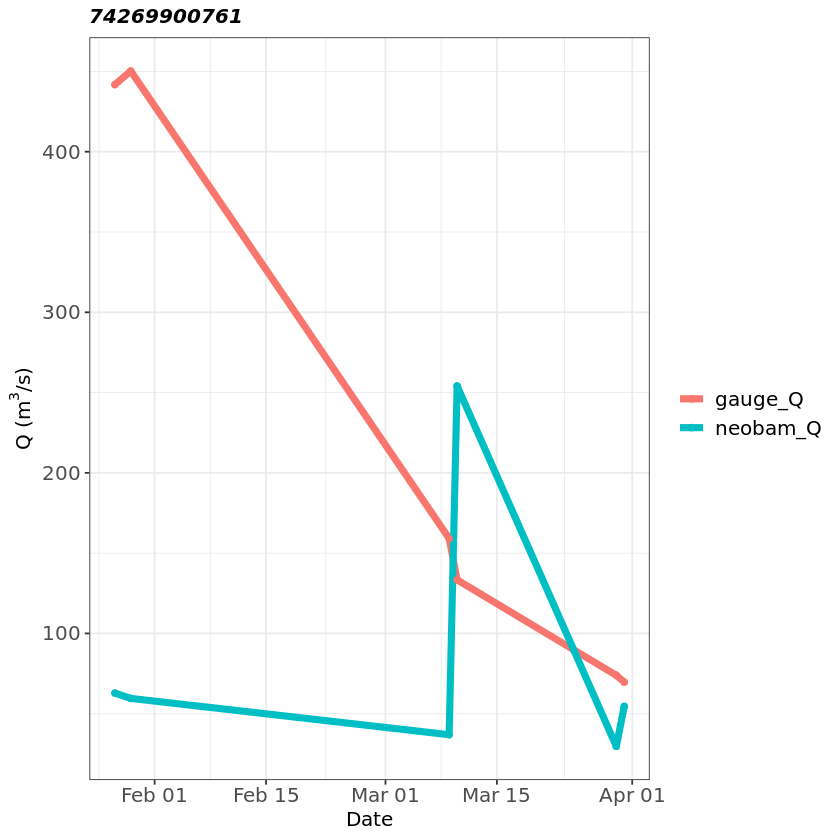

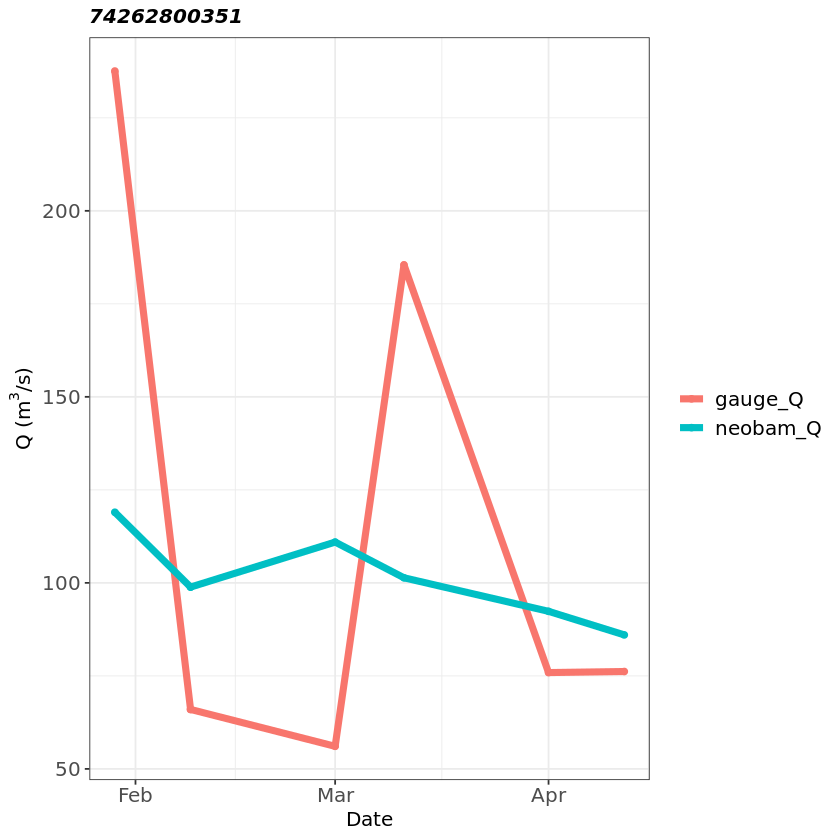

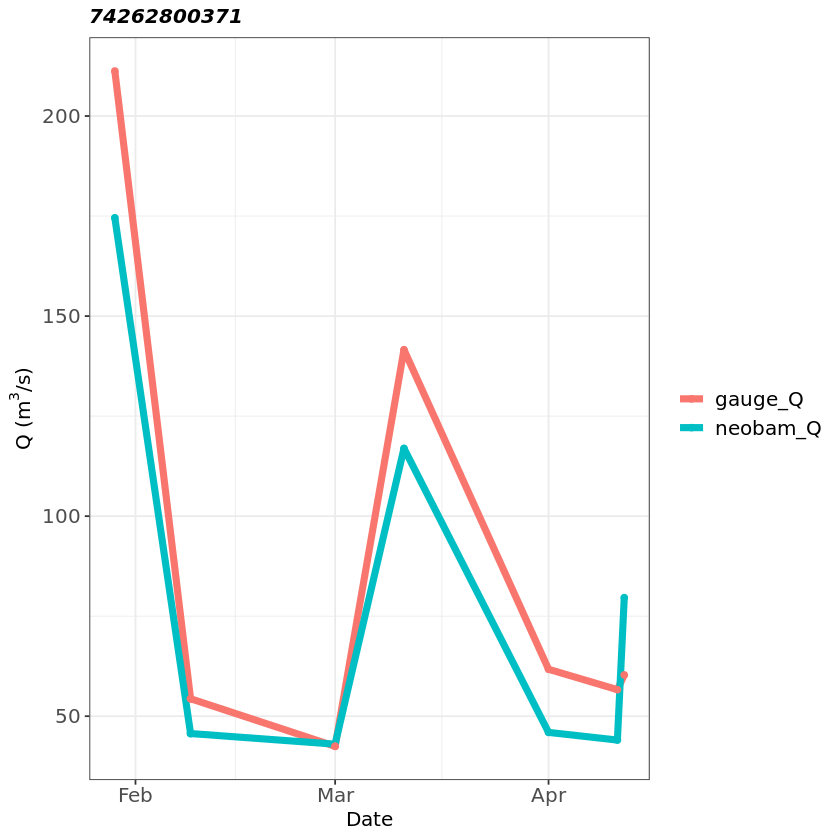

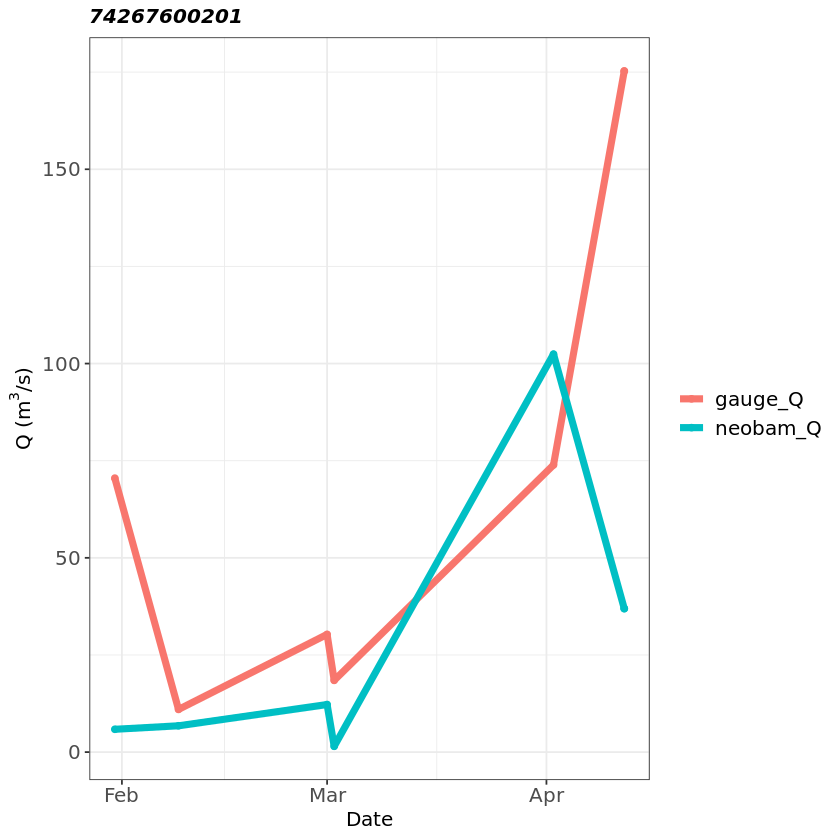

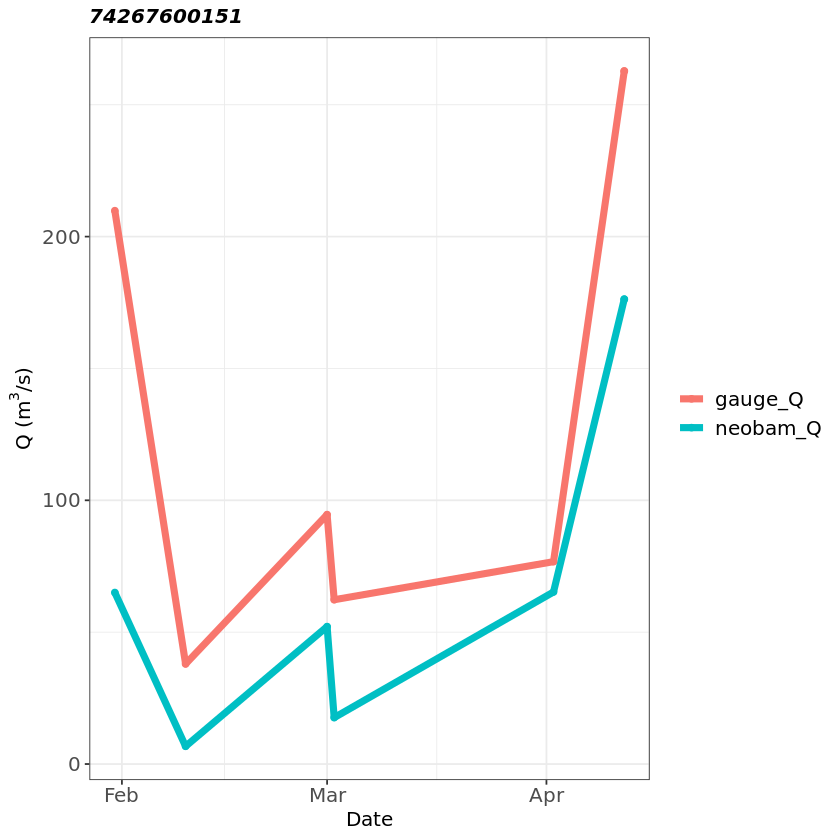

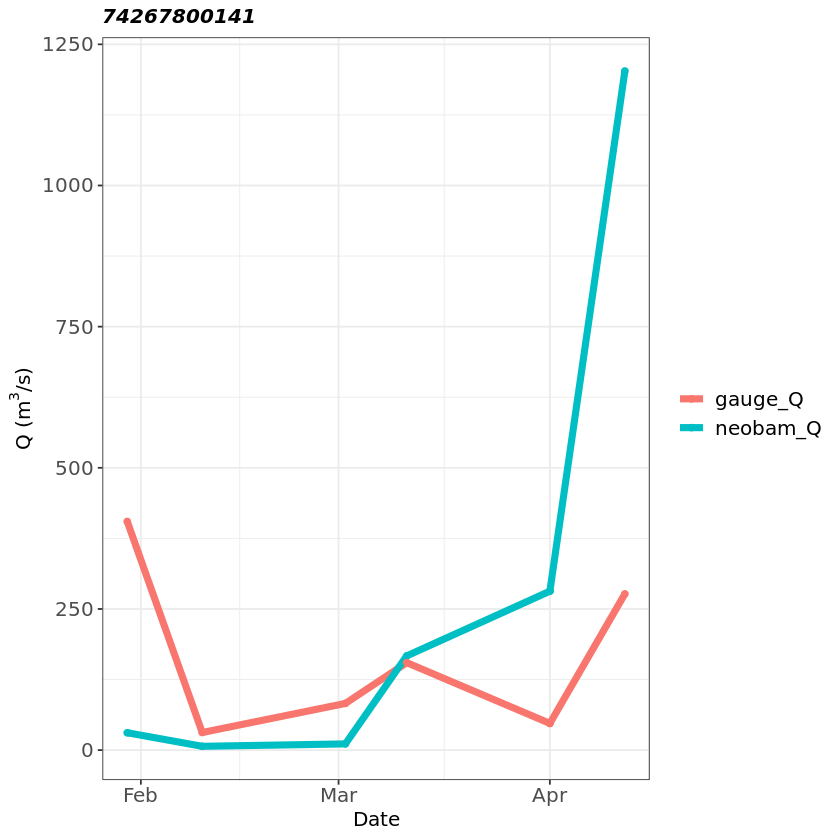

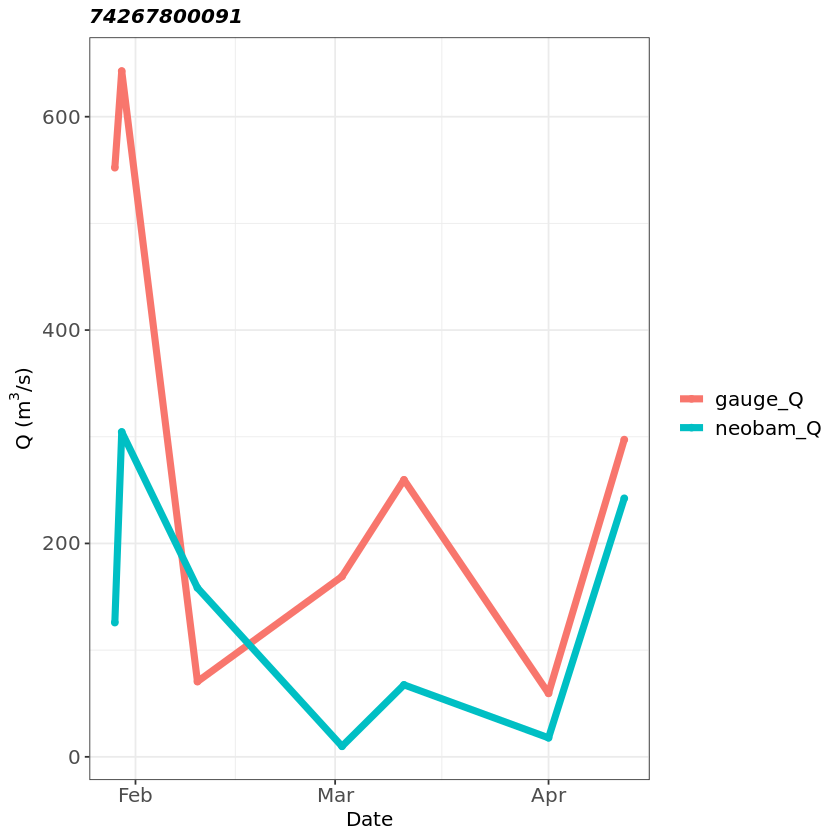

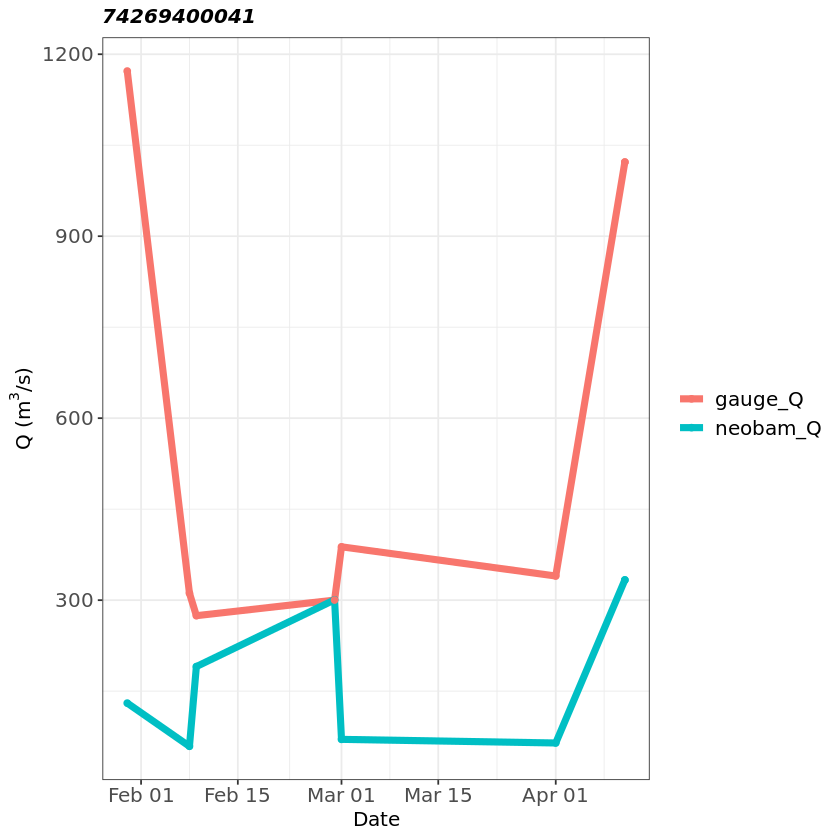

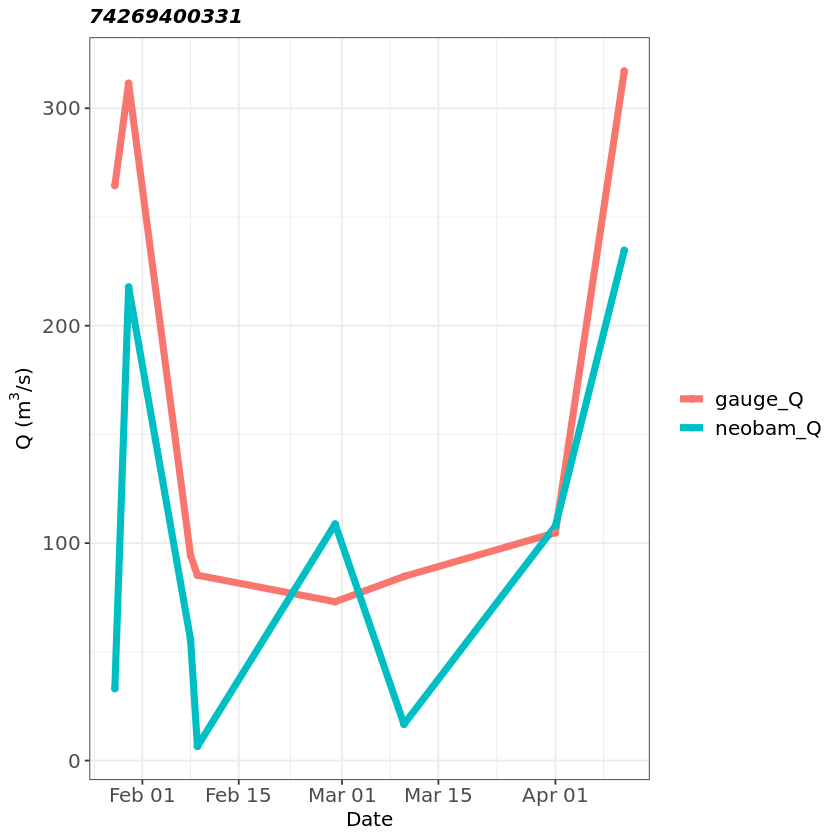

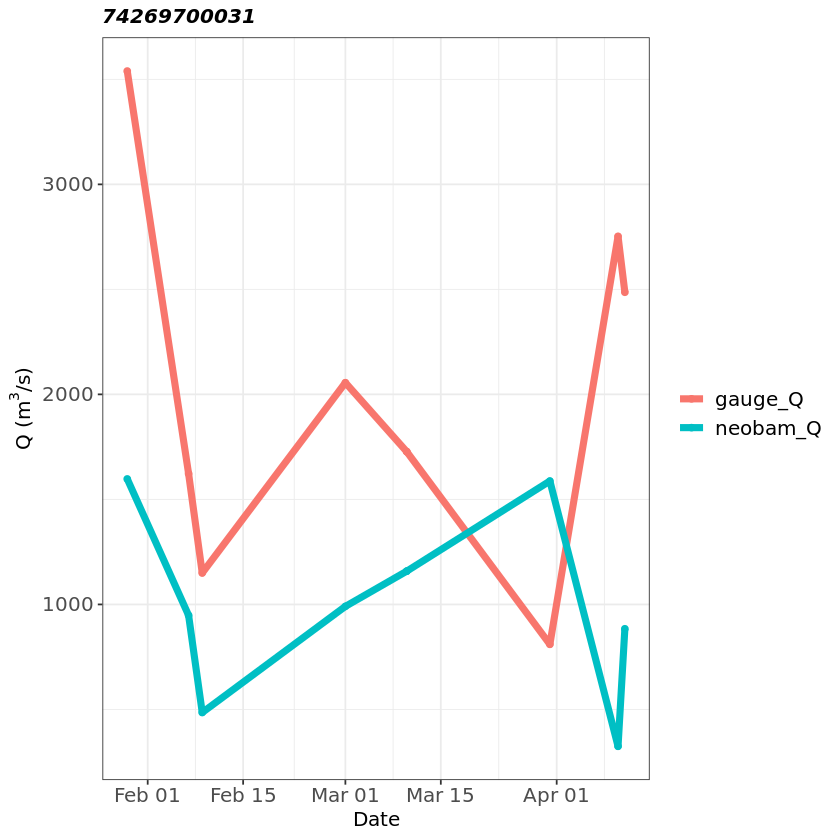

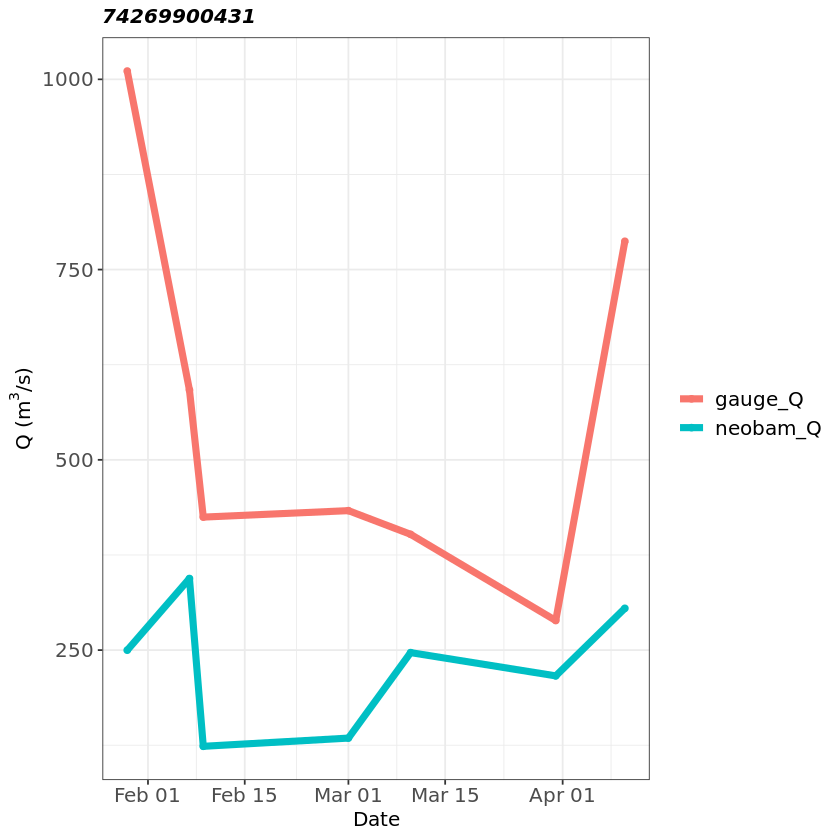

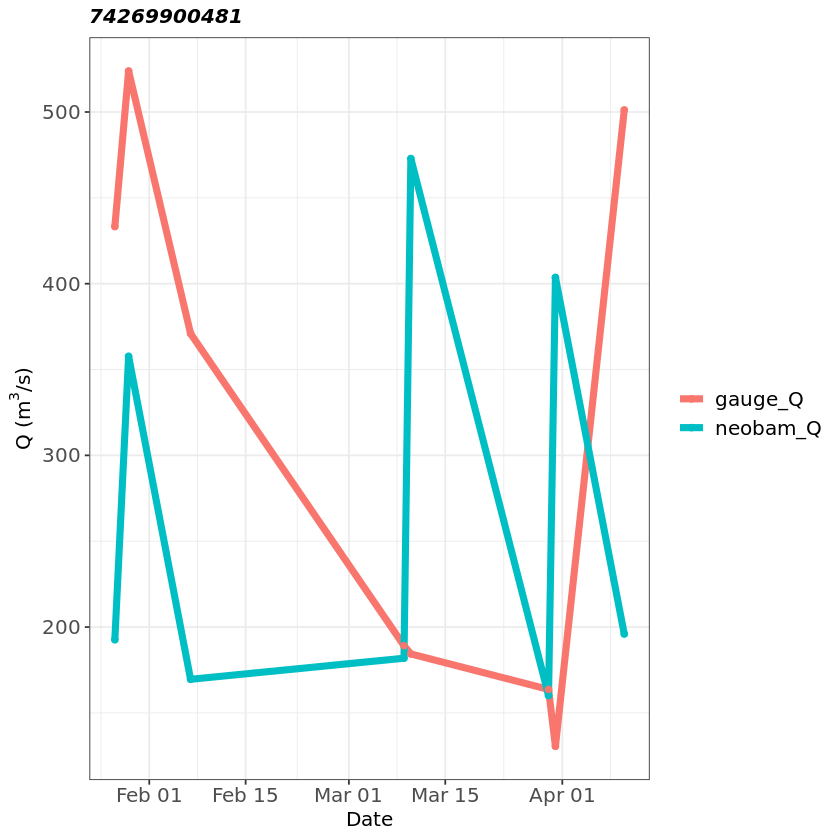

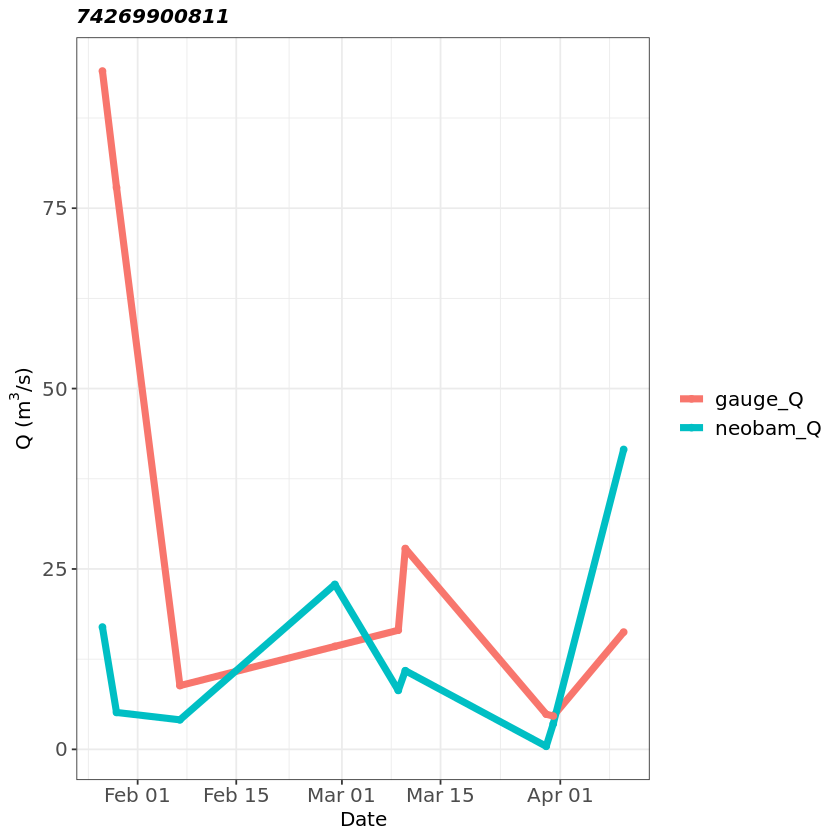

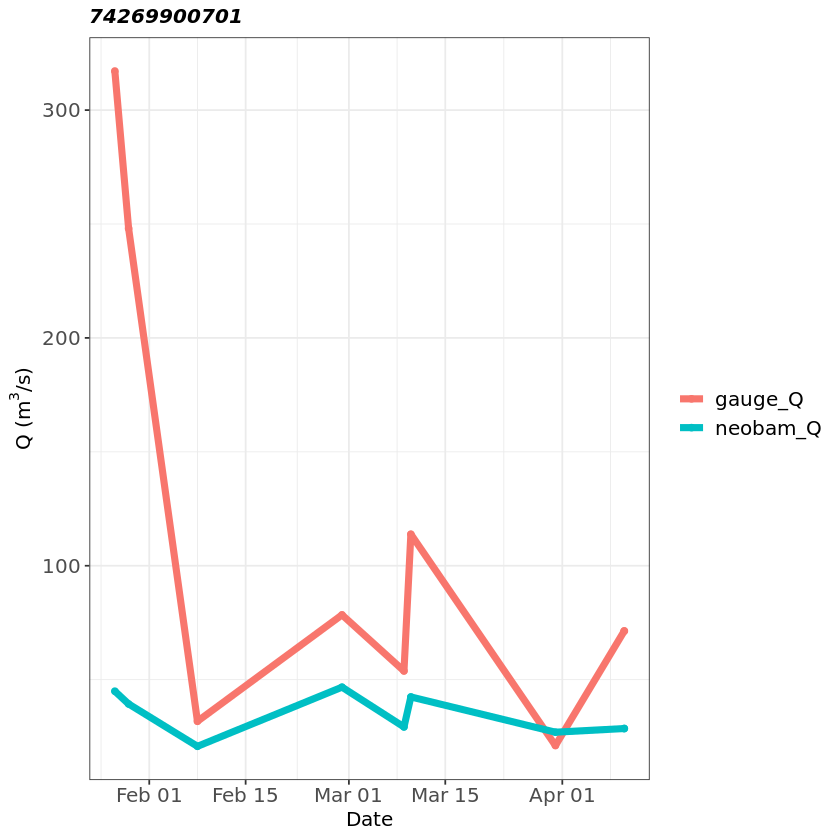

In [53]:
for (file in list.files('/nas/cee-water/cjgleason/colin/neobam/tempoutput/',full.names=TRUE)){
     # print(neobam_output)
neobam_output=readRDS(file)

if(is.null(neobam_output[[1]]$posteriors[[1]]$r$sd)){
    
    # print(neobam_output[[1]])
    

library(ggplot2)
library(ncdf4)
reach_id=neobam_output[[1]]$reach_id


swot_file= paste0('/nas/cee-water/cjgleason/SWOT_Q_UMASS/mnt/input/swot/',reach_id,
         '_SWOT.nc')     
#  swot = open.nc(swot_file)
# reach_grp = grp.inq.nc(swot, "reach")$self
# time = var.get.nc(reach_grp, "time")

swot=nc_open(swot_file)
time=ncvar_get(swot,'reach/time')
    
    invalid_times=neobam_output[[1]]$invalid_times
    
 if(length(invalid_times)==0){
     neobam_time=time}else{
  neobam_time = time[-invalid_times]}

  neobam_dt=as.character(as.Date(as.Date(neobam_time/86400,origin = '2000-01-01'),format='%Y%m%d'))
 nc_close(swot)

 # priors=open.nc("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")
priors=nc_open("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")

# priors_reach_grp=grp.inq.nc(priors,"reaches")$self
# priors_reach_index=which(var.get.nc(priors_reach_grp,'reach_id')==reach_id)

priors_reach_index=which(ncvar_get(priors,'USGS/USGS_reach_id')==reach_id)

# print(priors_reach_index)
#  gauge_grp=grp.inq.nc(priors, "USGS")$self
#  gauge_time=var.get.nc(gauge_grp,'USGS_qt')#[priors_reach_index,]
#  gauge_Q=var.get.nc(gauge_grp,'USGS_q')[priors_reach_index,]

gauge_time=t(ncvar_get(priors,'USGS/USGS_qt'))[priors_reach_index,]
gauge_Q=t(ncvar_get(priors,'USGS/USGS_q'))[priors_reach_index,]

 nc_close(priors)

 gauge_dt= as.character(as.Date(gauge_time, origin = '0001-01-01'))


  gauge_in_neobam_index=which(gauge_dt %in% neobam_dt)
        
 plotter_neobam= data.frame('neobam_Q'=neobam_output[[1]]$posterior_Q,
                            'time'=neobam_dt)

plotter_gauge= data.frame('gauge_Q'=gauge_Q[gauge_in_neobam_index],
                    'time'=gauge_dt[gauge_in_neobam_index])

plotter=left_join(plotter_neobam,plotter_gauge,by='time')%>%
      group_by(time)%>%
      mutate(neobam_Q=mean(neobam_Q))%>%
gather(source,flow,-time)%>%
mutate(time=as.POSIXct(time))

               
     nt=neobam_output$nt 

p1=ggplot(plotter)+
geom_line(aes(x=time,y=flow,col=source),lwd=2)+
    geom_point(aes(x=time,y=flow,col=source))+
  ylab(expression(paste("Q (",m^3, "/s)", sep="")))+
    xlab("Date")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +
   # annotate('text',x=min(plotter$date),y=1.0*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_posterior=',formatC(neobam_rrmse_posterior,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.95*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_posterior=',formatC(neobam_NSE_posterior,digits=2)) , size=4,hjust = 0) +
   #  annotate('text',x=min(plotter$date),y=0.90*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_recon=',formatC(neobam_rrmse_recon,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.85*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_recon=',formatC(neobam_NSE_recon,digits=2)) , size=4,hjust = 0) +
    ggtitle(reach_id)+

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=12),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=12),
        #legend.position = 'none',
        axis.text.x =element_text(size=12),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=12),
            axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  
         
        plot(p1)
    
    }
    
    }
    
    
      


In [4]:
set_json= '/nas/cee-water/cjgleason/colin/neosets_na.json'
sos_file='/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc'
setwd('/nas/cee-water/cjgleason/colin/neobam_reach/neobam/')


 total_sets=length(rjson::fromJSON(file=file.path(set_json)))

for (set_index in seq(1,total_sets)){
    # print(set_index)
  outname=paste0('/nas/cee-water/cjgleason/colin/neobam_reach/tempoutput/output',as.character(set_index),'.rds')
  source('/nas/cee-water/cjgleason/colin/neobam_reach/neobam/run_neobam.R')
    saveRDS(neobam_output,file=outname)}


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_model_base” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

rstan (Version 2.21.7, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘reshape2’


The followi

[1] "Total execution time for set 136 : 12.5140132904053 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 146 : 9.10021185874939 seconds."


Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to

[1] "Total execution time for set 158 : 8.36014151573181 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.43, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 215 : 4.29587936401367 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.54, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 362 : 3.60135579109192 seconds."


Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.75, indicating chains have not mixed.
Runn

[1] "Total execution time for set 390 : 5.87245059013367 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.18, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 436 : 3.57113409042358 seconds."


Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to

[1] "Total execution time for set 442 : 6.4915988445282 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.78, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 489 : 10.5332593917847 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.82, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 490 : 6.91252493858337 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.7, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“B

[1] "Total execution time for set 491 : 5.73912477493286 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.55, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 492 : 3.91873979568481 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.82, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 494 : 6.17302942276001 seconds."


Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.71, indicating chains have not mixed.
Runn

[1] "Total execution time for set 496 : 3.22909283638 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 497 : 6.90422511100769 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for set 552 : 5.50752806663513 seconds."


Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”
Warning message in names(Sobs) == names(Wobs):
“longer object length is not a multiple of shorter object length”


In [5]:
# list(readRDS('/nas/cee-water/cjgleason/colin/neobam_reach/tempoutput/output1.rds')
count=0
 for (file in list.files('/nas/cee-water/cjgleason/colin/neobam_reach/tempoutput/',full.names=TRUE)){
     # print(neobam_output)
neobam_output=readRDS(file)
     
     # print(typeof(neobam_output))
if(typeof(neobam_output)=='list' ){
    
    count=count+1
 
   }
}
    
       print(count)


[1] 16


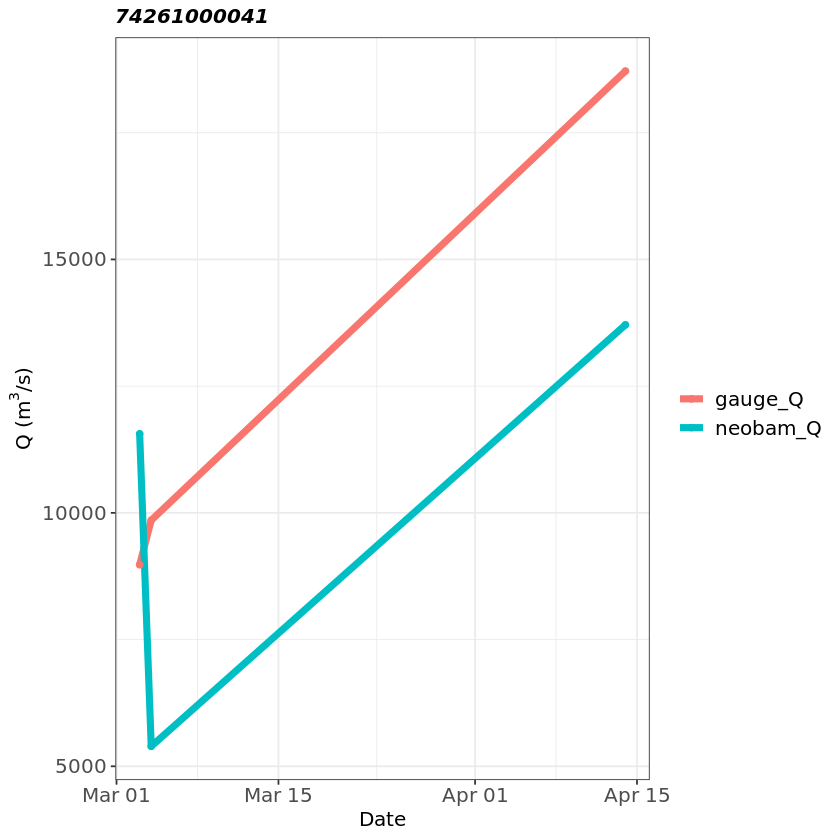

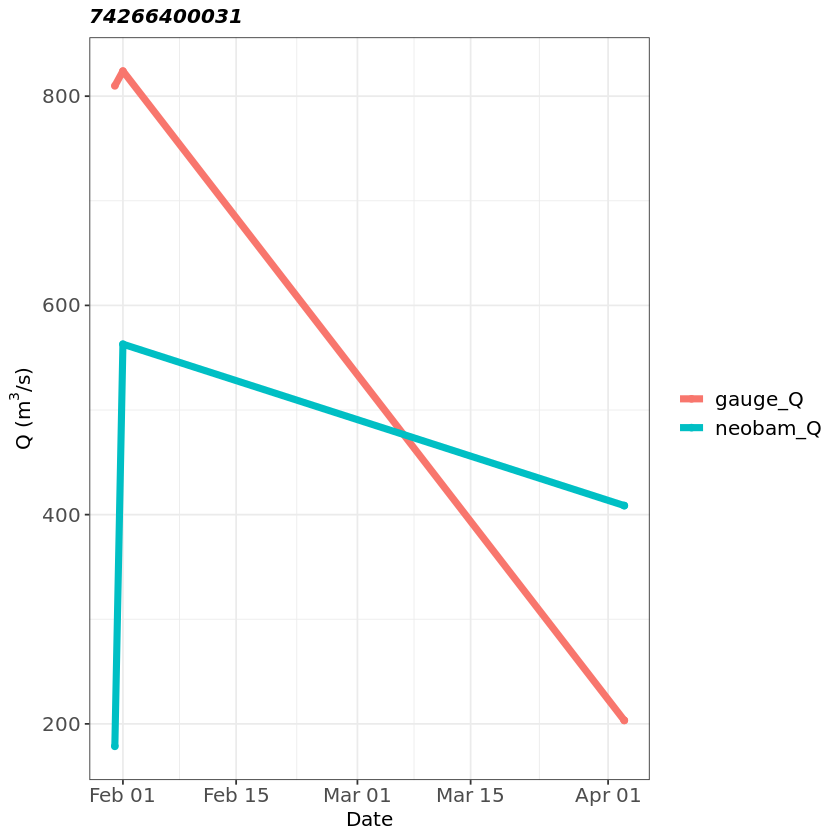

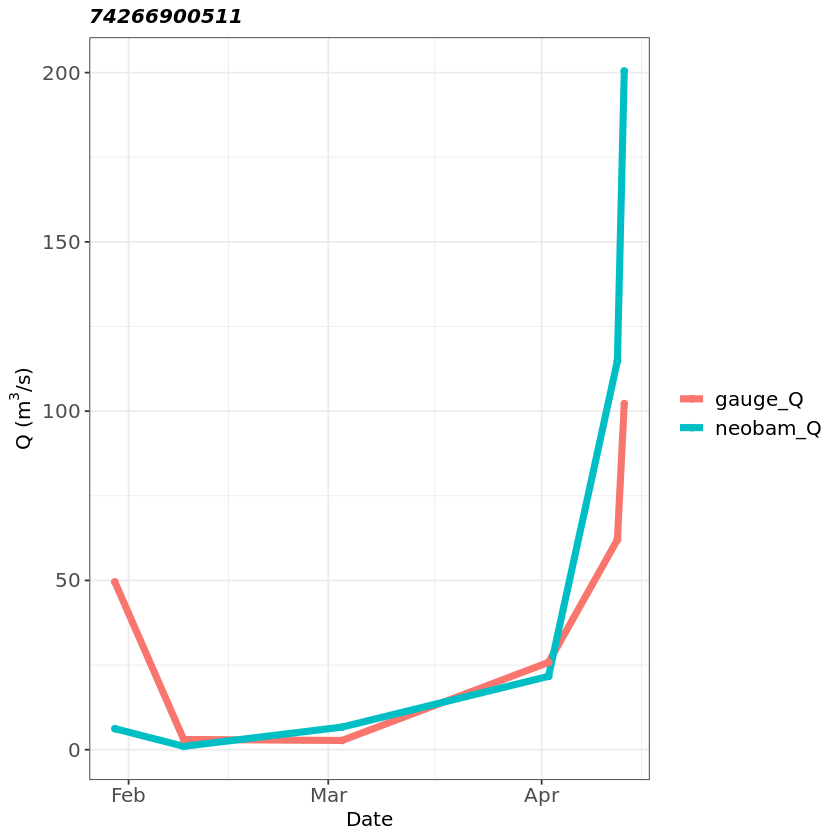

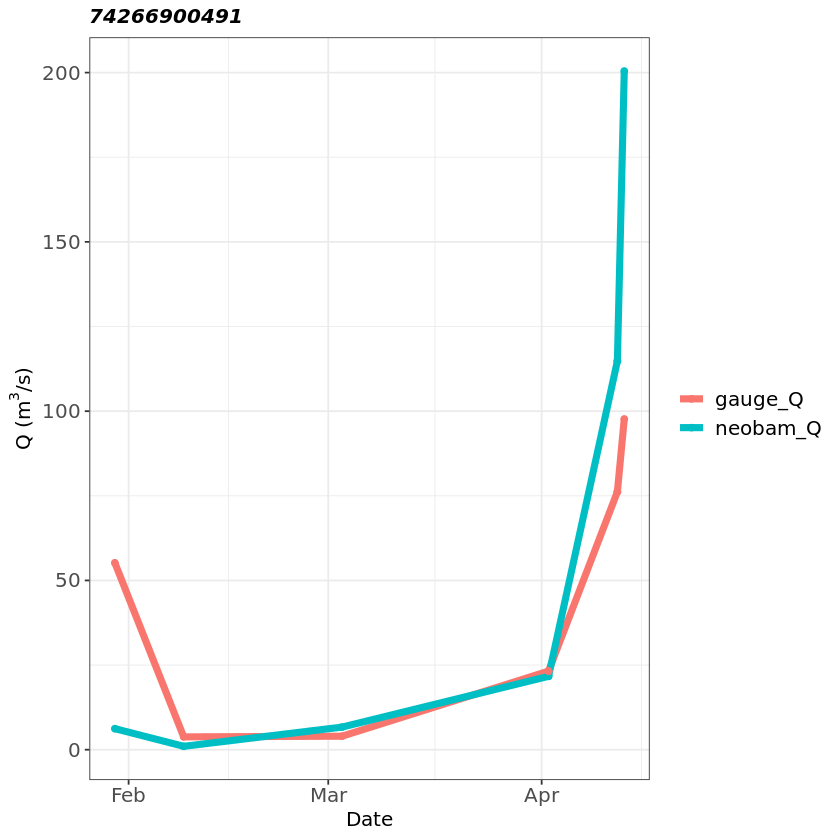

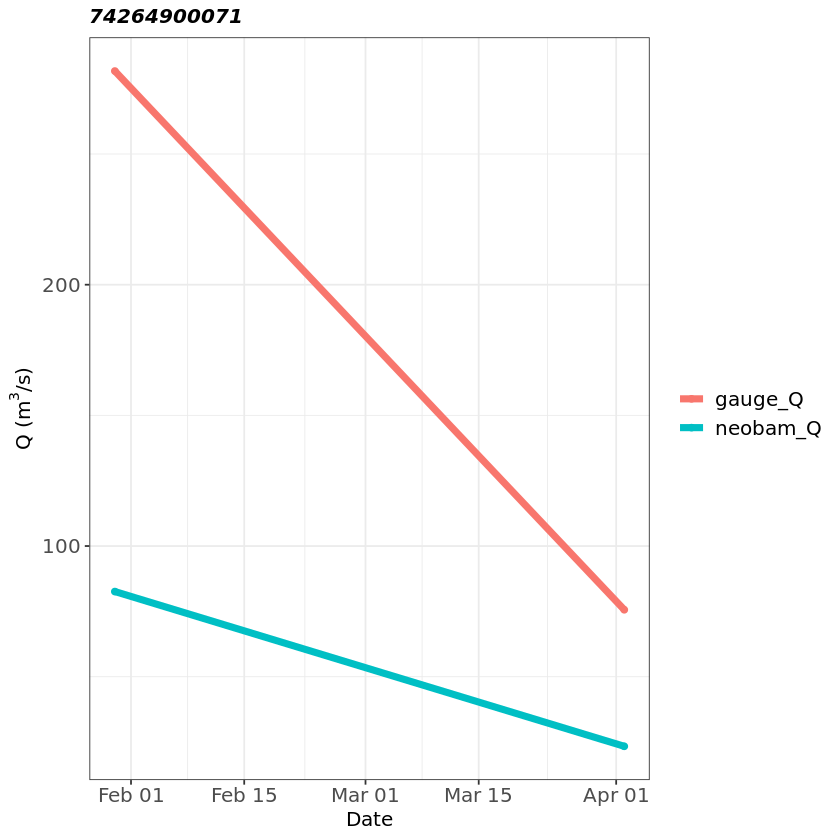

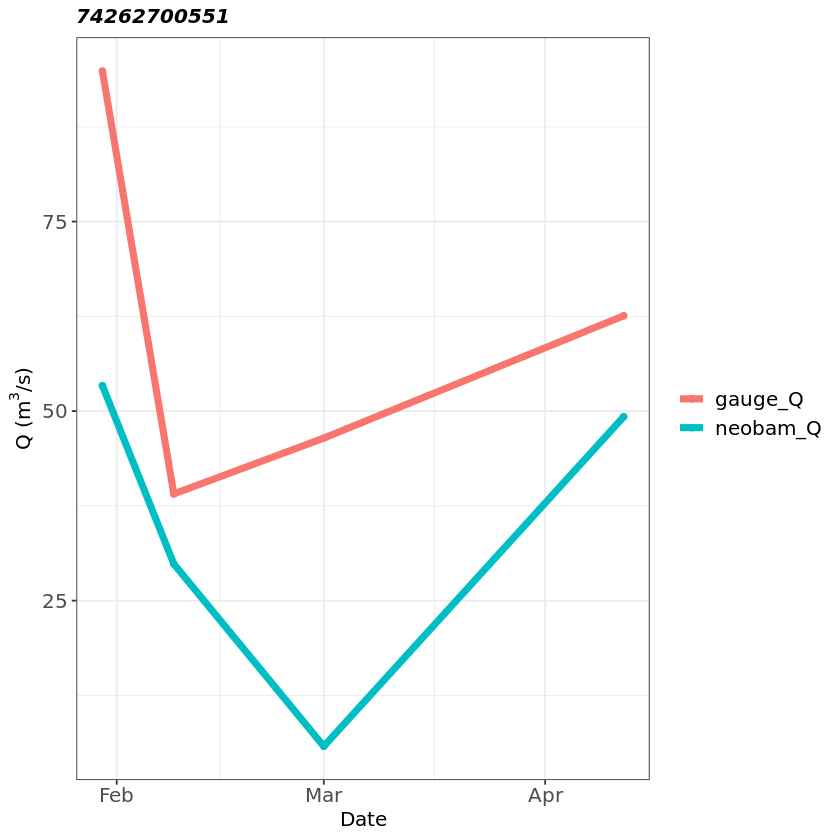

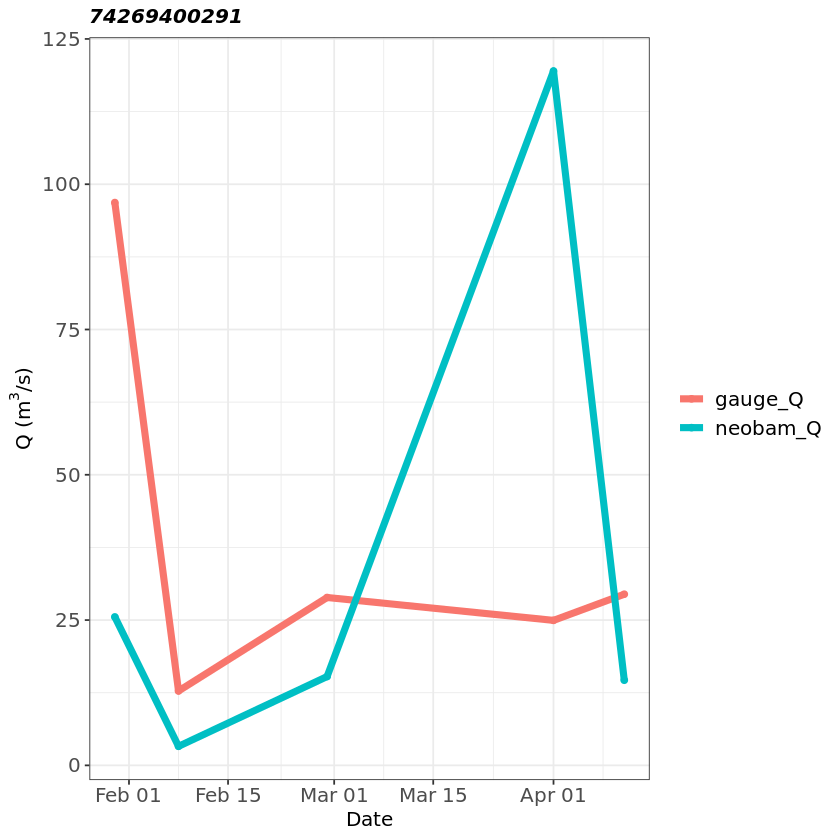

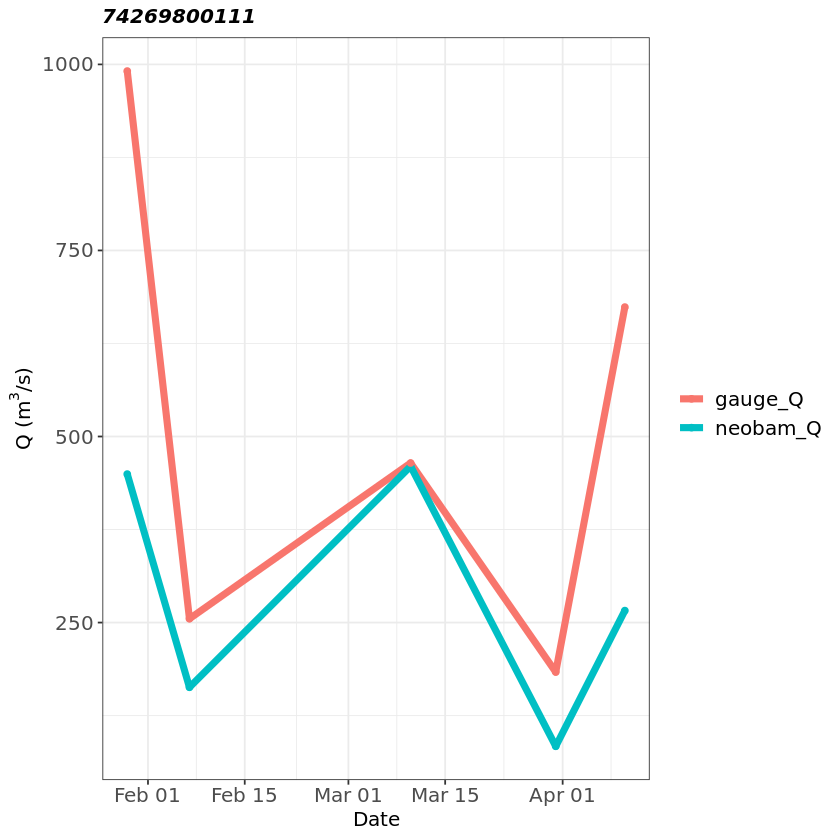

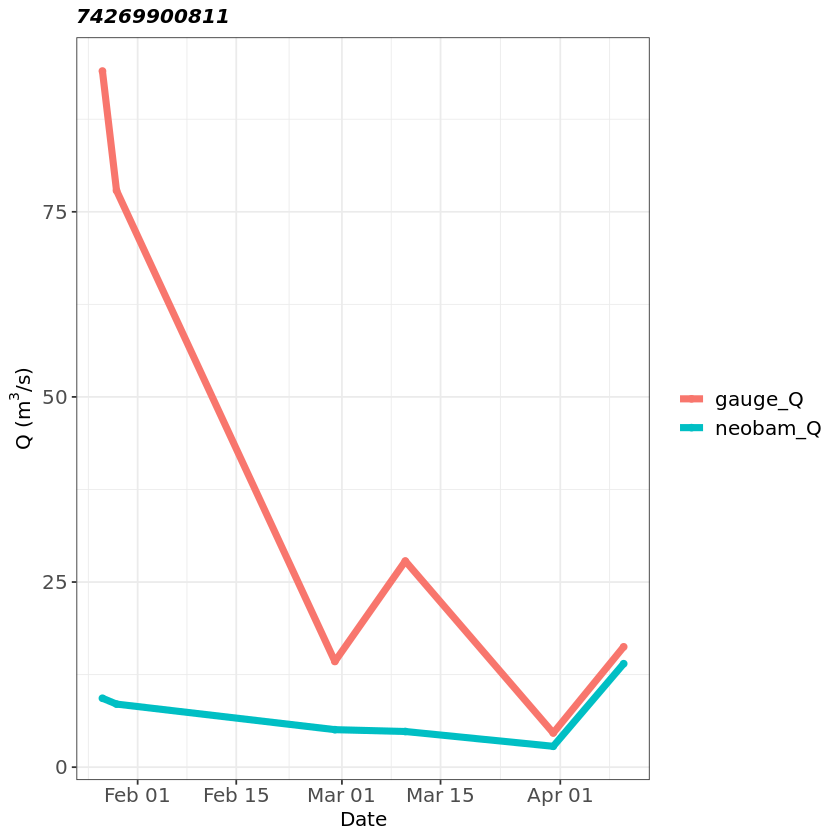

Warning message:
“Removed 5 row(s) containing missing values (geom_path).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


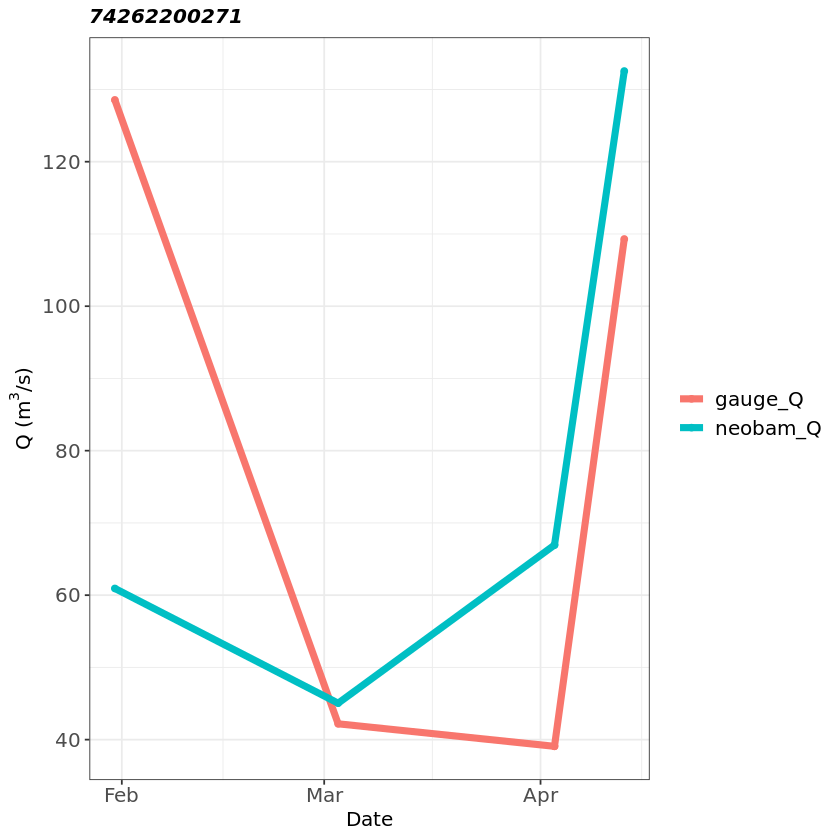

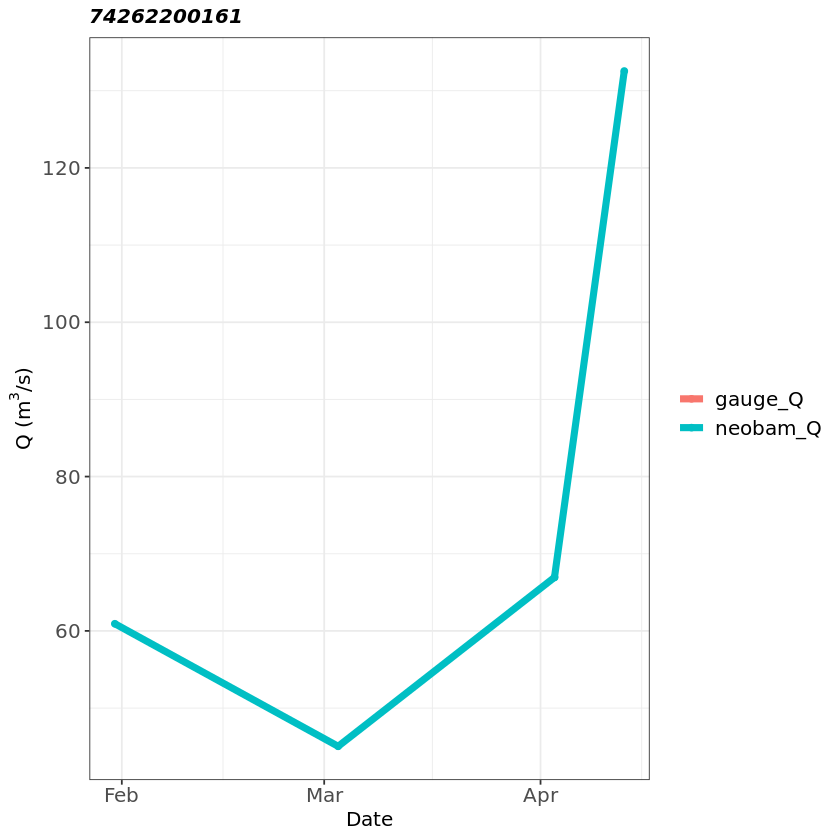

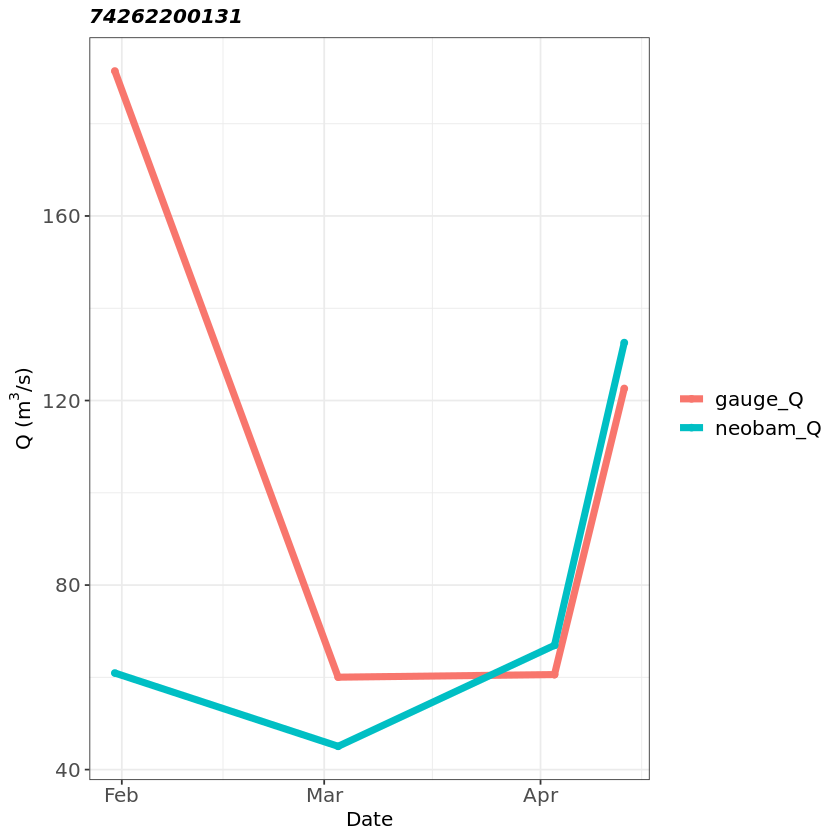

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


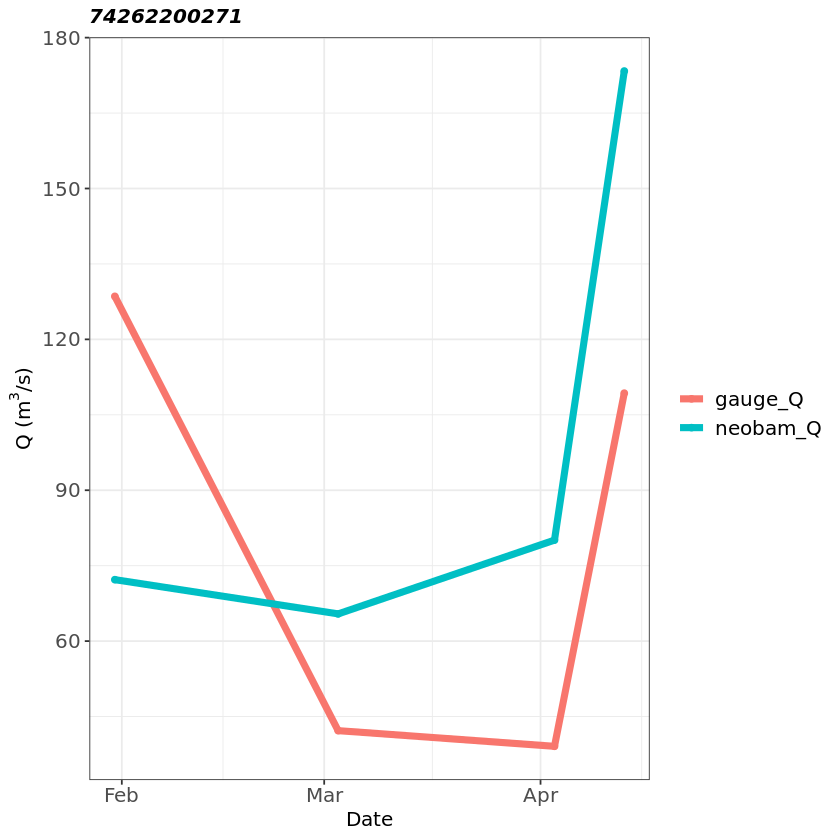

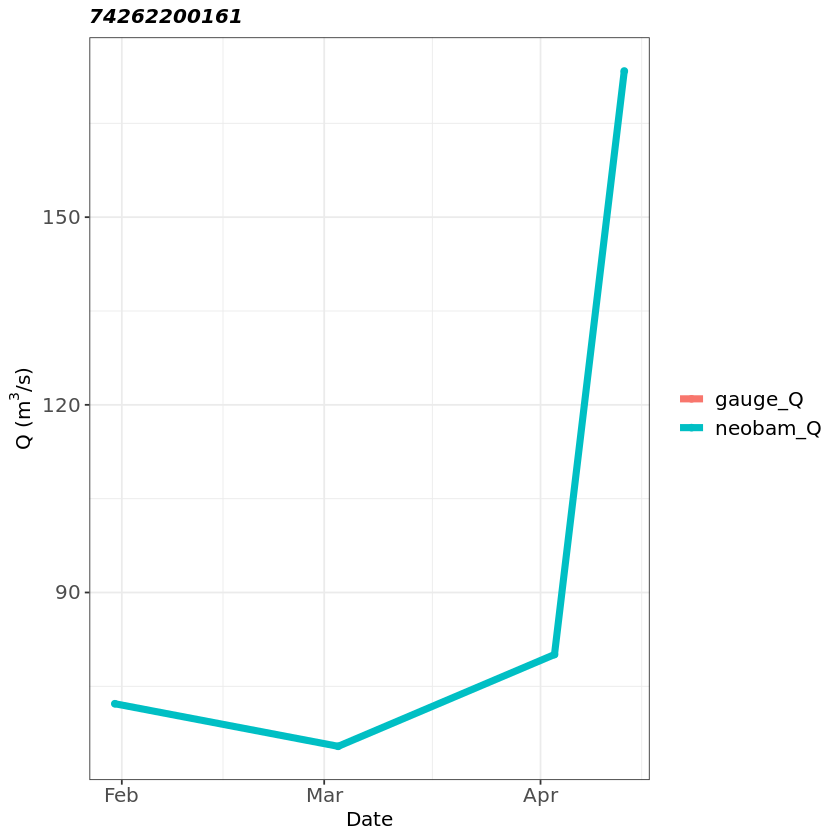

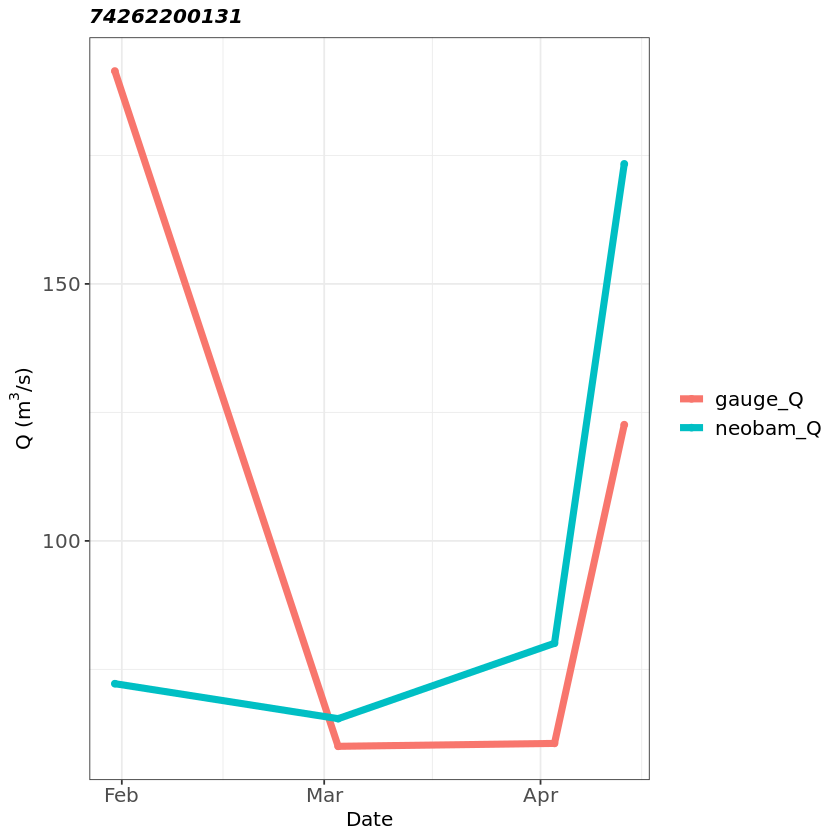

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 rows containing missing values (geom_point).”


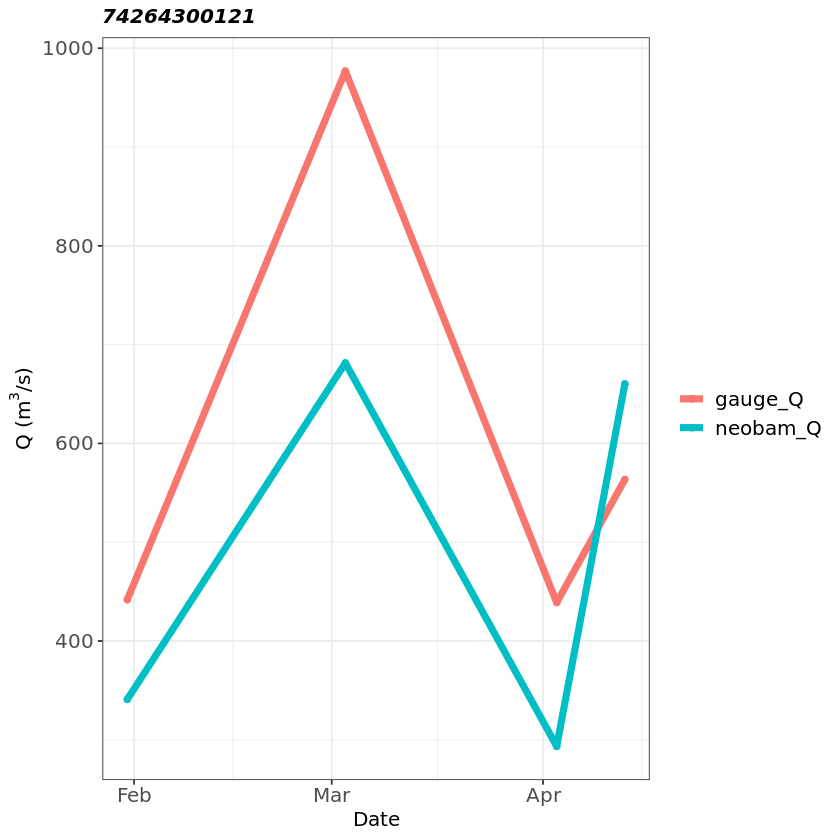

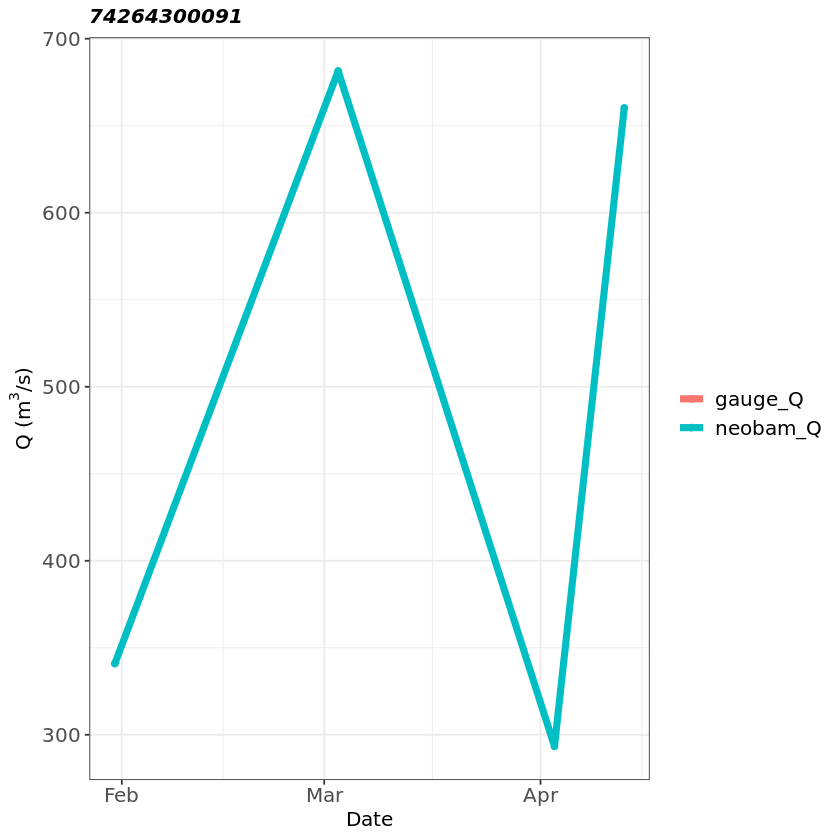

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


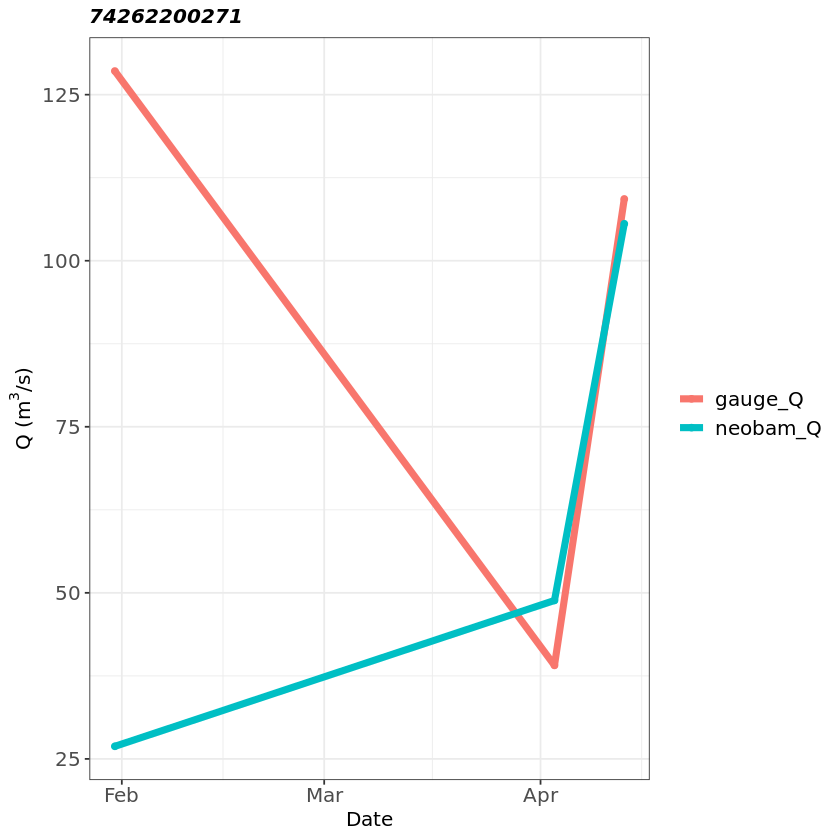

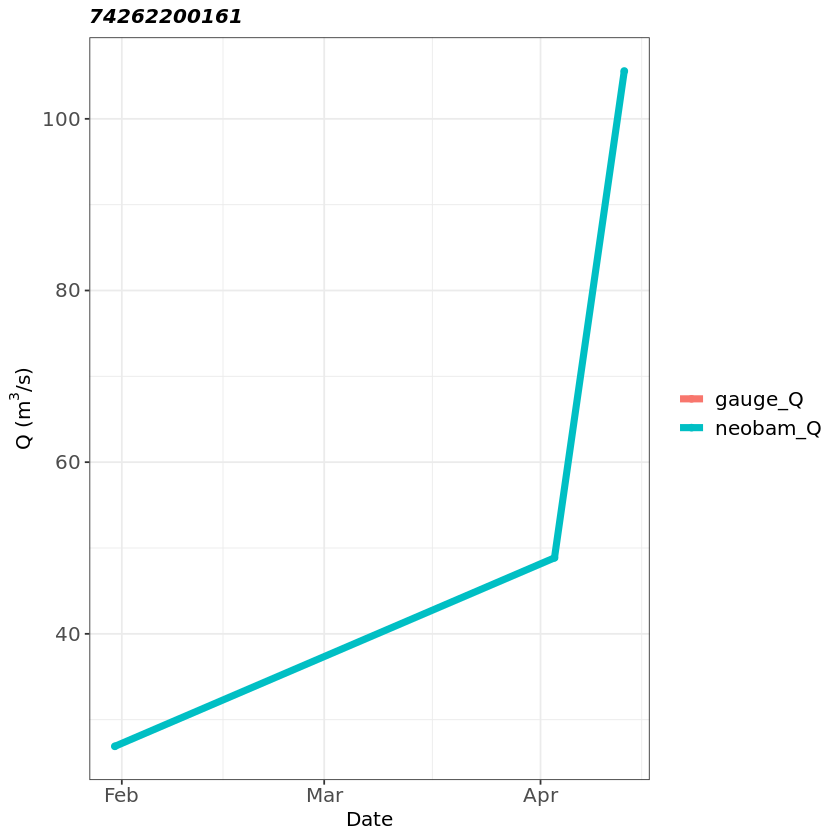

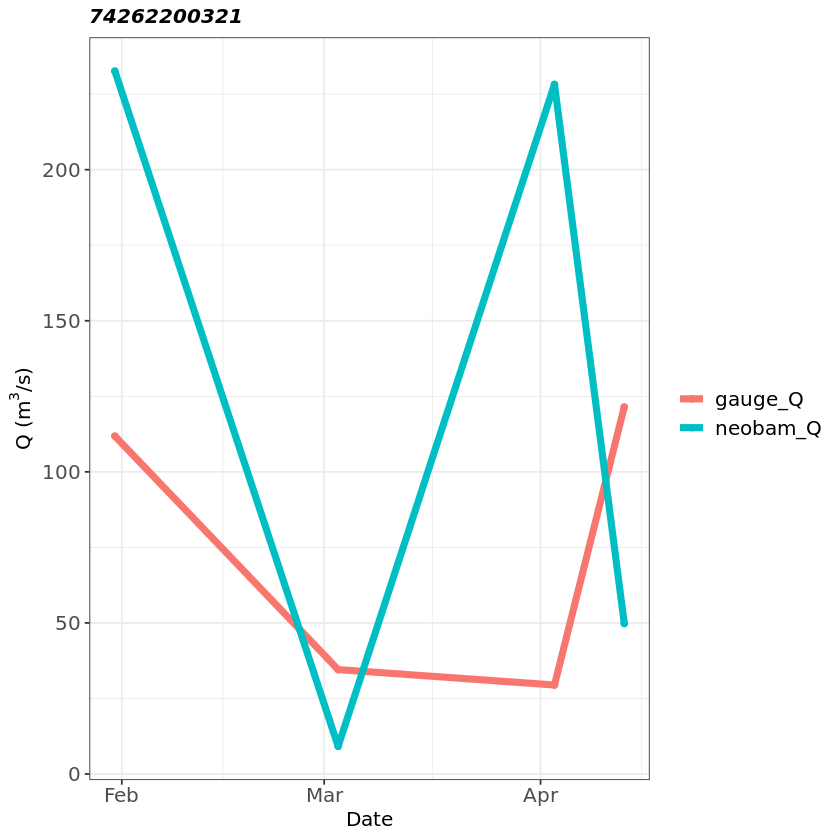

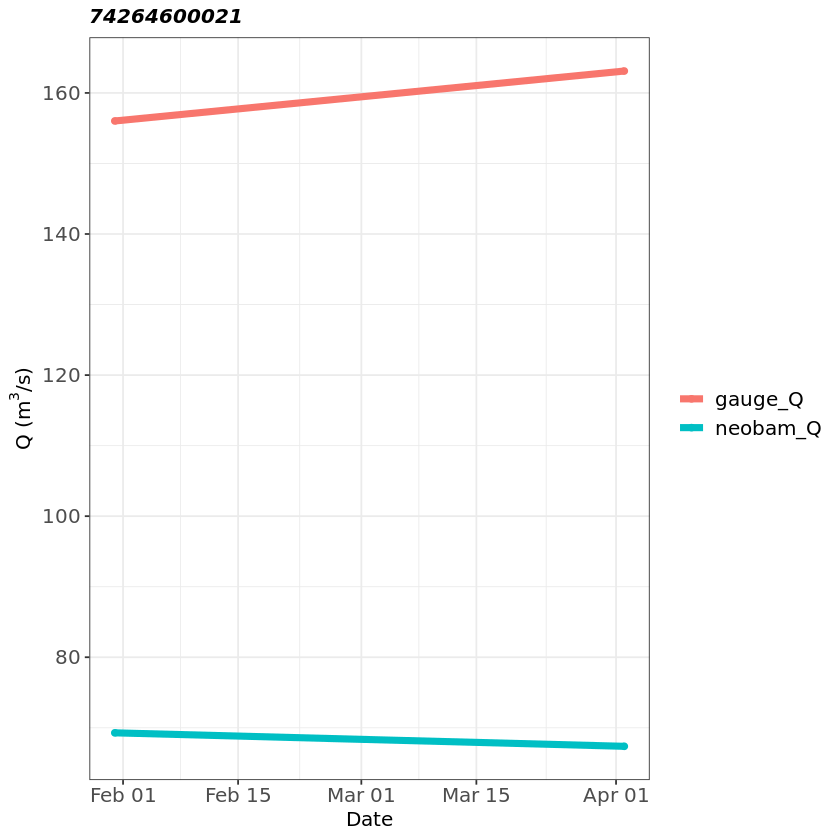

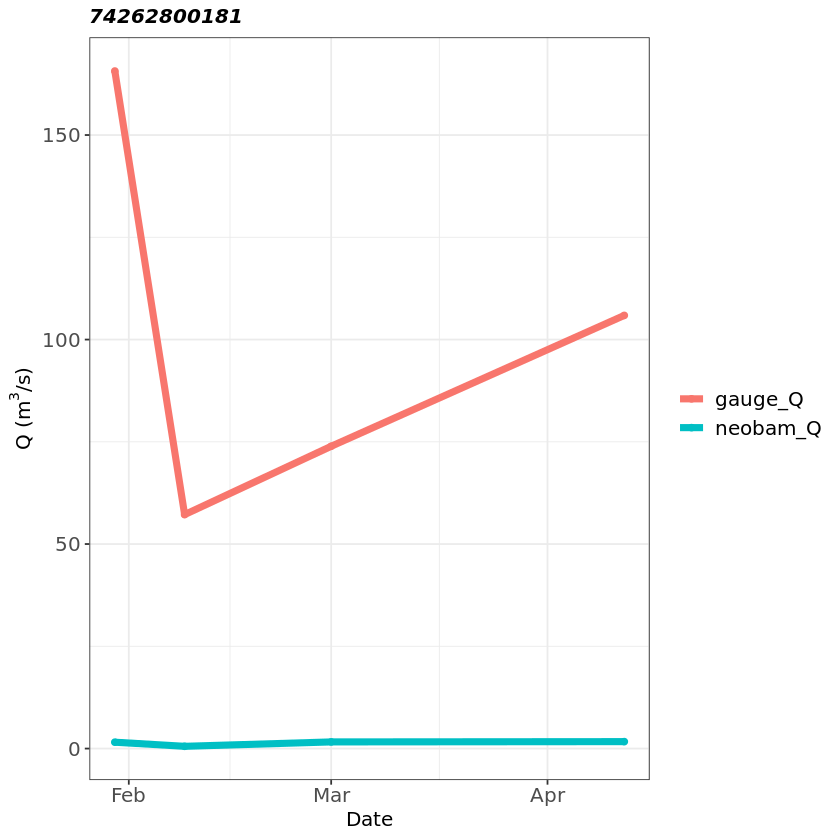

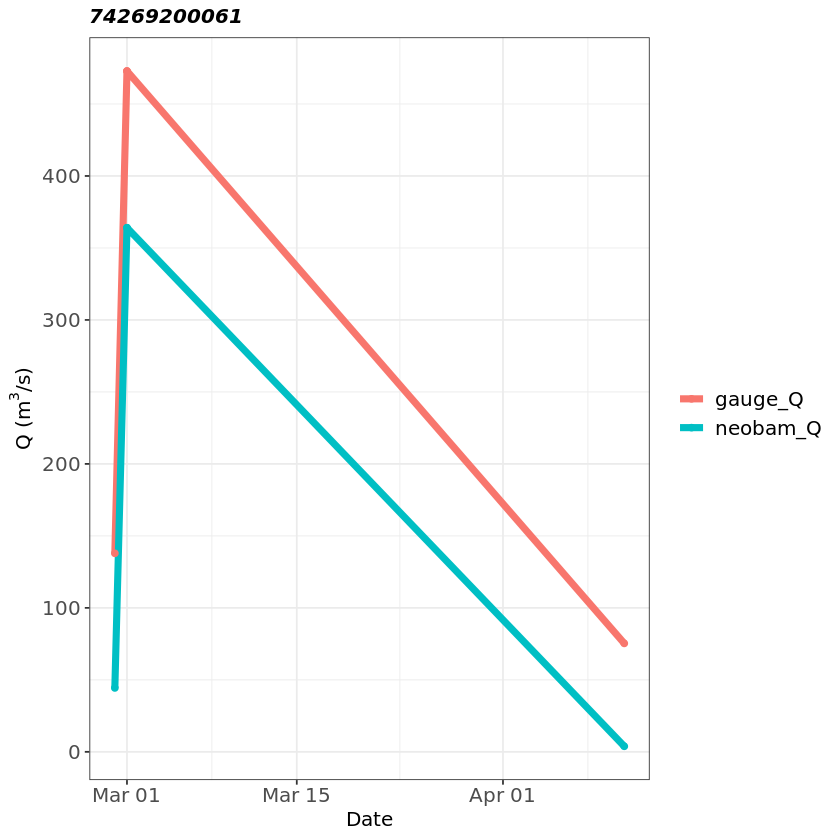

In [11]:
for (file in list.files('/nas/cee-water/cjgleason/colin/neobam_reach/tempoutput/',full.names=TRUE)){
     # print(neobam_output)

neobam_output=readRDS(file)
    if(typeof(neobam_output)=='list' ){
library(ggplot2)
library(ncdf4)
    

for (reach_id in unlist(neobam_output$reach_id)){
    


neobam_time=as.integer(neobam_output$time)
  neobam_dt=as.character(as.Date(as.Date(neobam_time/86400,origin = '2000-01-01'),format='%Y%m%d'))

    
 # priors=open.nc("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")
priors=nc_open("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")

# priors_reach_grp=grp.inq.nc(priors,"reaches")$self
# priors_reach_index=which(var.get.nc(priors_reach_grp,'reach_id')==reach_id)

priors_reach_index=which(ncvar_get(priors,'USGS/USGS_reach_id')==reach_id)

# print(priors_reach_index)
#  gauge_grp=grp.inq.nc(priors, "USGS")$self
#  gauge_time=var.get.nc(gauge_grp,'USGS_qt')#[priors_reach_index,]
#  gauge_Q=var.get.nc(gauge_grp,'USGS_q')[priors_reach_index,]

gauge_time=t(ncvar_get(priors,'USGS/USGS_qt'))[priors_reach_index,]
gauge_Q=t(ncvar_get(priors,'USGS/USGS_q'))[priors_reach_index,]
    
 nc_close(priors)
    

if(length(gauge_Q !=0)){
    
#     print(reach_id)
#     print(neobam_dt)
#     print(gauge_time)
#     print(gauge_Q)
    
#     bonk

 gauge_dt= as.character(as.Date(gauge_time, origin = '0001-01-01'))


  gauge_in_neobam_index=which(gauge_dt %in% neobam_dt)
    
        
 plotter_neobam= data.frame('neobam_Q'=neobam_output$neobam_output$posterior_Q,
                            'time'=neobam_dt)

plotter_gauge= data.frame('gauge_Q'=gauge_Q[gauge_in_neobam_index],
                    'time'=gauge_dt[gauge_in_neobam_index])%>%
    dplyr::filter(!is.na(gauge_Q))
    

plotter=left_join(plotter_neobam,plotter_gauge,by='time')%>%
      group_by(time)%>%
      mutate(neobam_Q=mean(neobam_Q))%>%
gather(source,flow,-time)%>%
mutate(time=as.POSIXct(time))

    

p1=ggplot(plotter)+
geom_line(aes(x=time,y=flow,col=source),lwd=2)+
    geom_point(aes(x=time,y=flow,col=source))+
  ylab(expression(paste("Q (",m^3, "/s)", sep="")))+
    xlab("Date")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +
   # annotate('text',x=min(plotter$date),y=1.0*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_posterior=',formatC(neobam_rrmse_posterior,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.95*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_posterior=',formatC(neobam_NSE_posterior,digits=2)) , size=4,hjust = 0) +
   #  annotate('text',x=min(plotter$date),y=0.90*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_recon=',formatC(neobam_rrmse_recon,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.85*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_recon=',formatC(neobam_NSE_recon,digits=2)) , size=4,hjust = 0) +
    ggtitle(reach_id)+

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=12),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=12),
        #legend.position = 'none',
        axis.text.x =element_text(size=12),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=12),
            axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  
  
         plot(p1)
    
    }
    
    }
    
    }
    
    
    
    }
      
